In [ ]:
!pip uninstall xgboost -y
!pip install -U xgboost

!pip uninstall scikit-learn -y
!pip install -U scikit-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
from dython import nominal

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import os

In [ ]:
# basedir = "/Users/thomaschampion/Dropbox/Programming/Projects/recidivism/"
basedir = '/content/drive/MyDrive/recidivism/'
raw_datadir = os.path.join(basedir,'data','01_raw')
interim_datadir = os.path.join(basedir,'data','02_interim')
processed_datadir = os.path.join(basedir,'data','03_processed')
modelsdir = os.path.join(basedir,'models')

In [ ]:
# data = pd.read_csv("../data/01_raw/NIJ_s_Recidivism_Challenge_Full_Dataset.csv")
data = pd.read_csv(os.path.join(raw_datadir,"NIJ_s_Recidivism_Challenge_Full_Dataset.csv"))

In [ ]:
data.shape

(25835, 54)

## Delete unnecessary features
* ID is an assigned unique identifier, does not impact outcome variable
* Recidivism_Arreyst_Year1,Recidivism_Arreyst_Year2, Recidivism_Arreyst_Year3 are all captured in Recidivism_Within_3years feature
* Taining_Sample does not impact outcome variable

In [ ]:
data = data.drop(columns=['ID', 'Recidivism_Arrest_Year1','Recidivism_Arrest_Year2','Recidivism_Arrest_Year3','Training_Sample'])
data.shape

(25835, 49)

### Save updated dataset and define numerical vs categorical features lists

In [ ]:

dir = os.path.join(basedir,interim_datadir,"cleaned_raw_data.csv")
data.to_csv(dir, header=True, index=False)

In [ ]:
num_features = ['Avg_Days_per_DrugTest', 'DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
cat_features = ['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA',
       'Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level', 'Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony',
       'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug',
       'Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony', 'Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug',
       'Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole',
       'Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Condition_Other', 'Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission', 'Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes',
       'Employment_Exempt']

## Summary Statistics for Numerical Features

In [ ]:
data[num_features].describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Days_per_DrugTest,19732.0,93.890044,117.169847,0.5,28.837366,55.424812,110.333333,1088.5
DrugTests_THC_Positive,20663.0,0.063350,0.138453,0.0,0.000000,0.000000,0.071429,1.0
DrugTests_Cocaine_Positive,20663.0,0.013741,0.061233,0.0,0.000000,0.000000,0.000000,1.0
DrugTests_Meth_Positive,20663.0,0.012890,0.060581,0.0,0.000000,0.000000,0.000000,1.0
DrugTests_Other_Positive,20663.0,0.007550,0.041150,0.0,0.000000,0.000000,0.000000,1.0
Percent_Days_Employed,25373.0,0.482331,0.425004,0.0,0.000000,0.475728,0.969325,1.0
Jobs_Per_Year,25027.0,0.769295,0.813787,0.0,0.000000,0.635217,1.000000,8.0


## Check for Missing Values

In [ ]:
isnull = data.isnull().sum()
isnull = pd.DataFrame(isnull, columns = ['count'])
isnull = isnull[isnull['count'] > 0]
isnull

,count
Gang_Affiliated,3167
Supervision_Risk_Score_First,475
Supervision_Level_First,1720
Prison_Offense,3277
Avg_Days_per_DrugTest,6103
DrugTests_THC_Positive,5172
DrugTests_Cocaine_Positive,5172
DrugTests_Meth_Positive,5172
DrugTests_Other_Positive,5172
Percent_Days_Employed,462


## Correlation of missing values with target variable


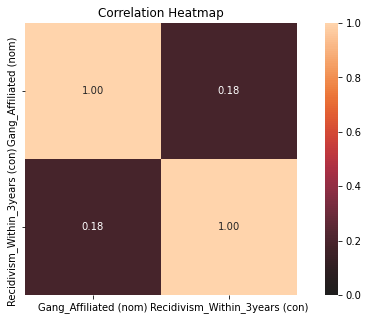

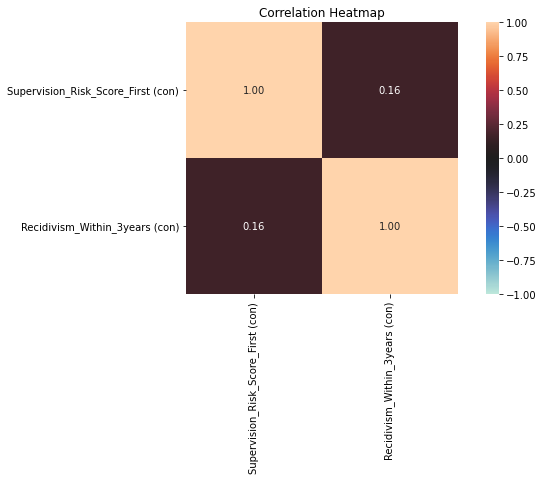

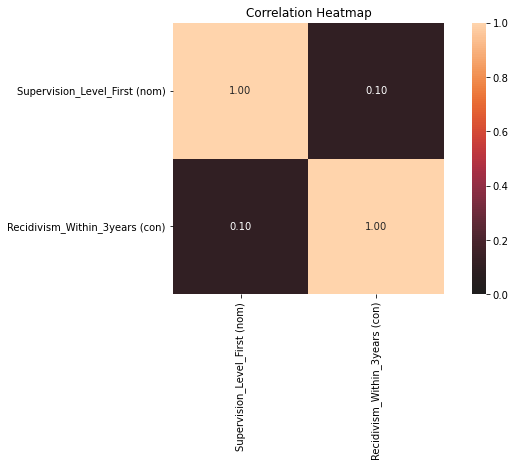

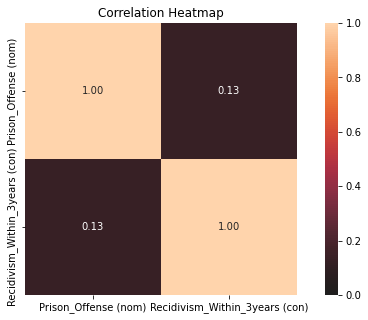

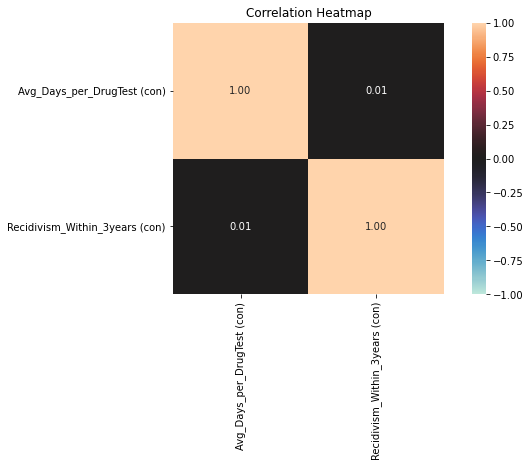

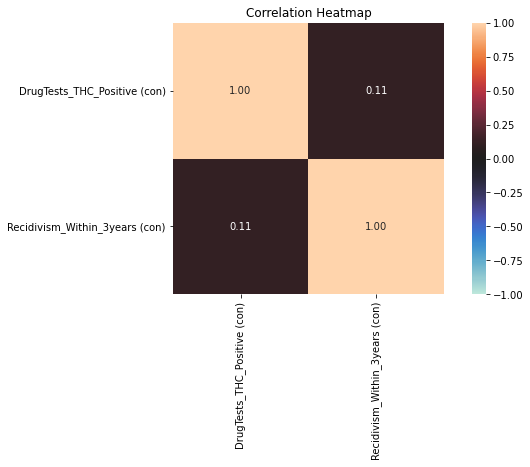

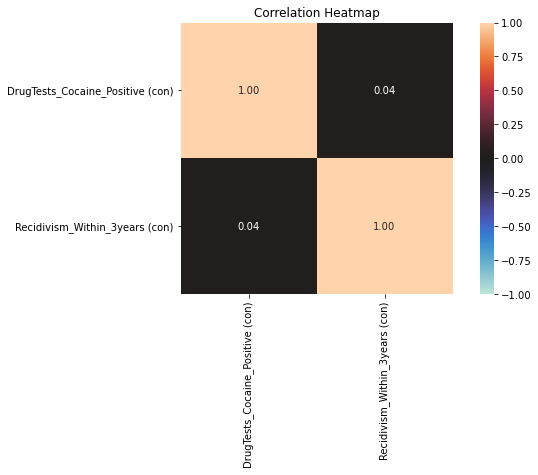

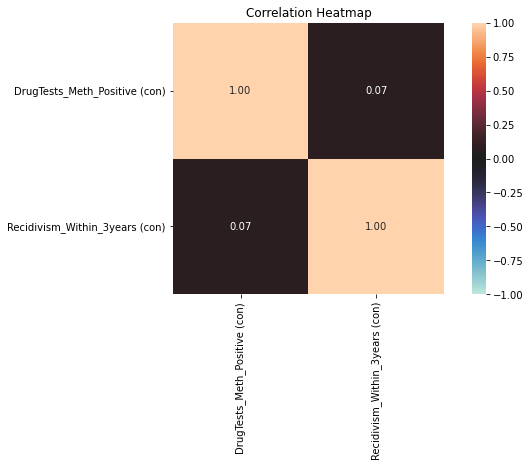

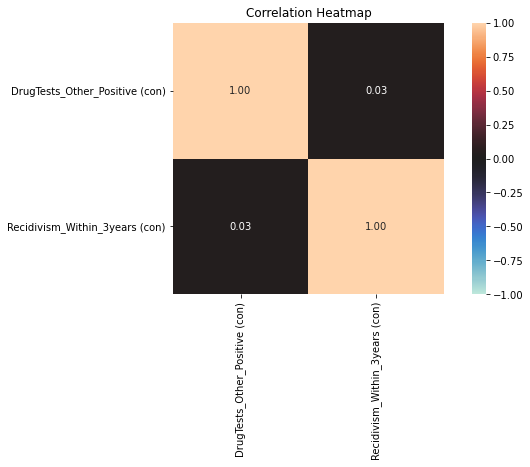

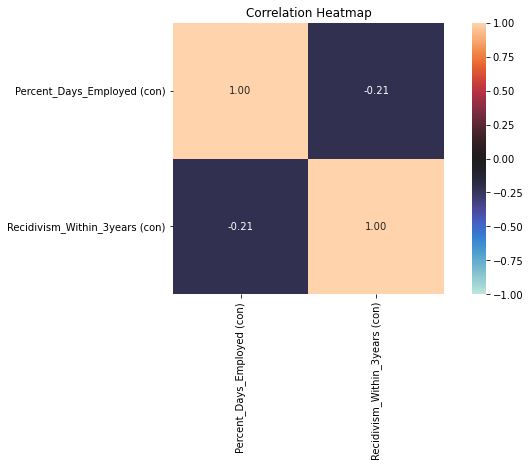

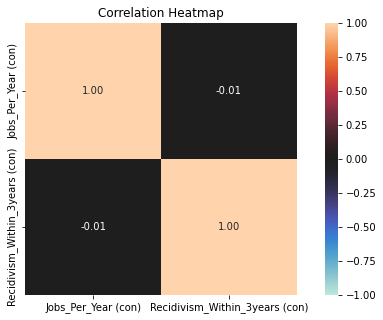

In [ ]:
for missing in isnull.index:
    df = data[[missing,'Recidivism_Within_3years']]
    nominal.associations(df,figsize=(10,5), mark_columns=True, title="Correlation Heatmap")

# Count Unique Values for Each Feature

In [ ]:
def unique_count(df):
    import pandas as pd
    dict = {}
    for i in list(df.columns):
        dict[i] = df[i].value_counts().shape[0]
    result = pd.DataFrame(dict, index=['unique count']).transpose()
    return result

In [ ]:
counts = unique_count(data)

In [ ]:
counts

,unique count
Gender,2
Race,2
Age_at_Release,7
Residence_PUMA,25
Gang_Affiliated,2
Supervision_Risk_Score_First,10
Supervision_Level_First,3
Education_Level,3
Dependents,4
Prison_Offense,5


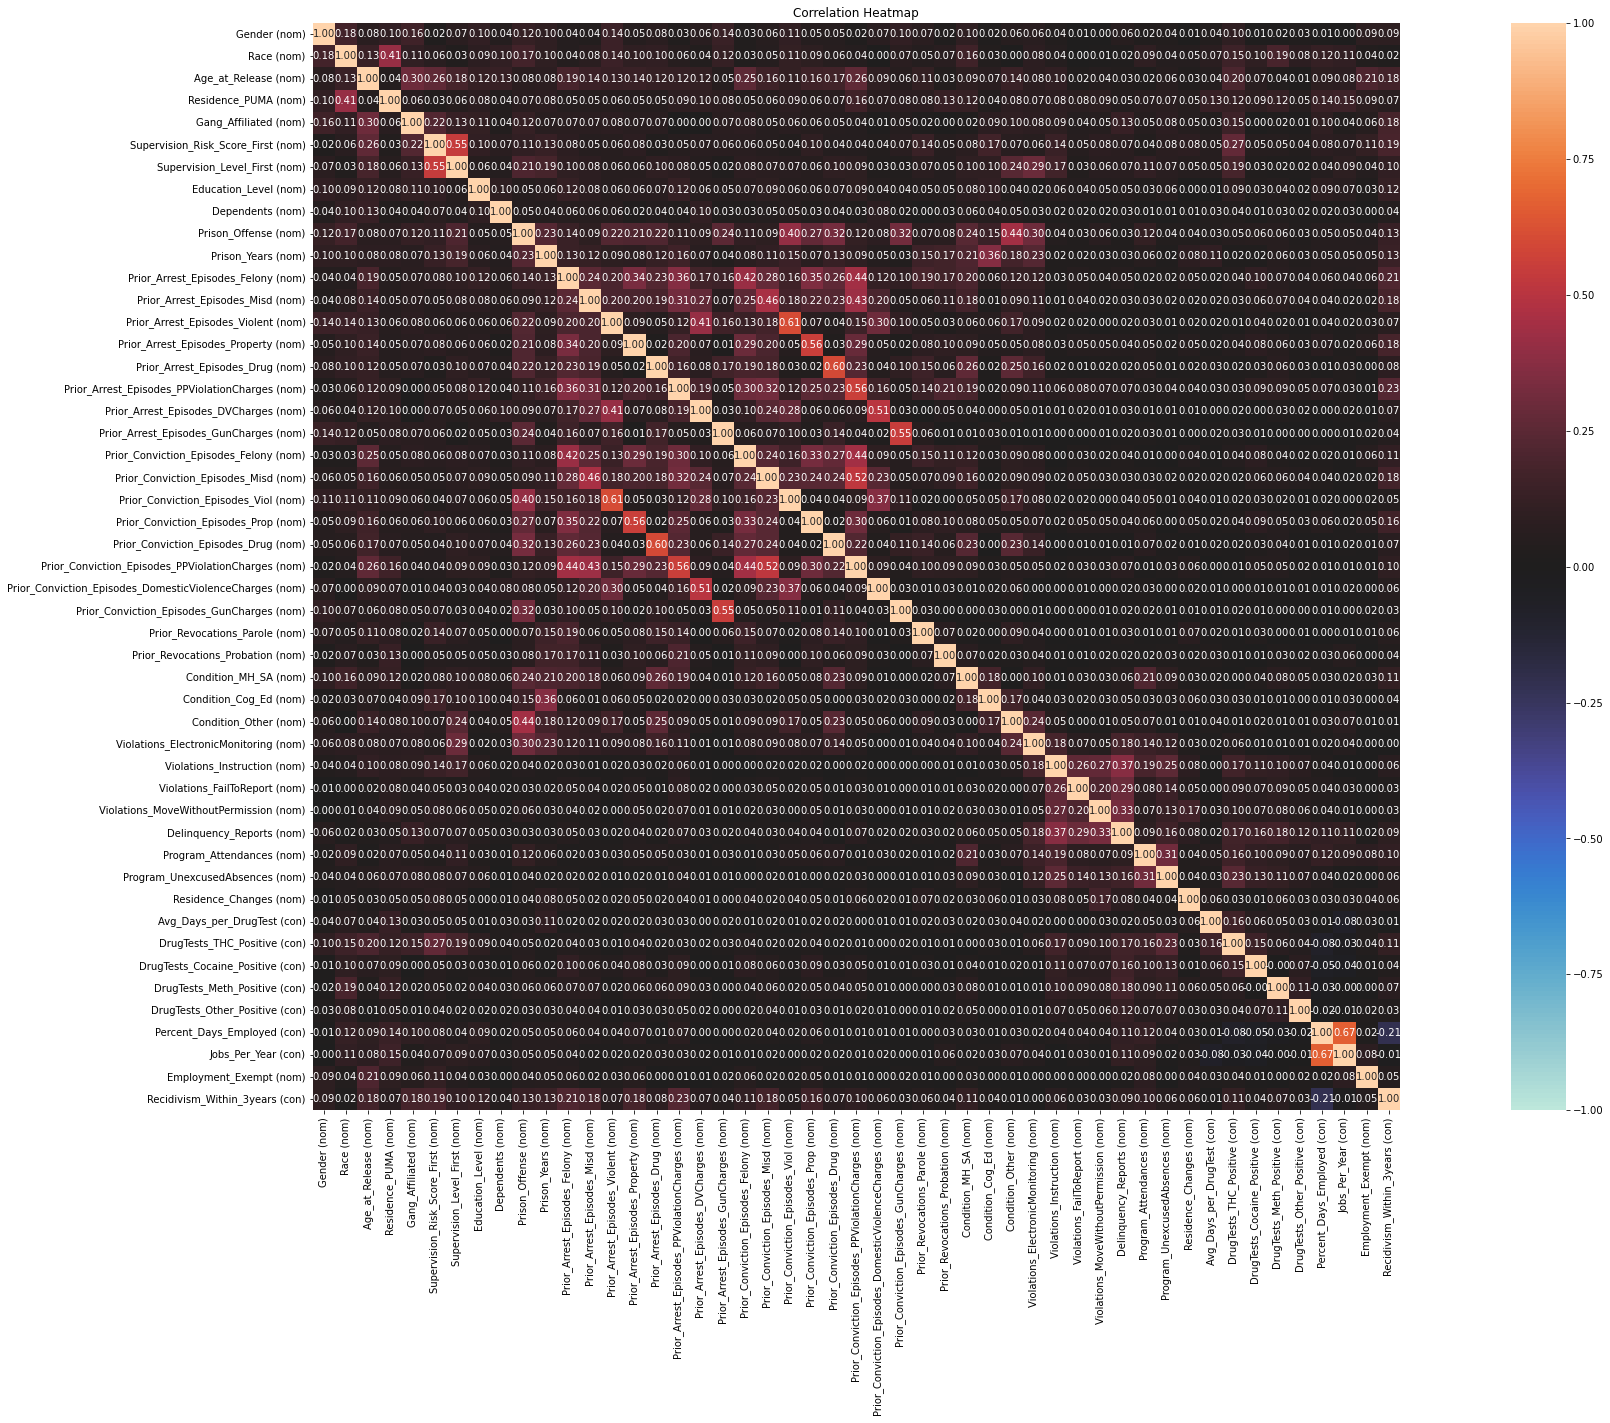

In [ ]:
nominal.associations(data, nominal_columns = cat_features,figsize=(40,20), mark_columns=True, title="Correlation Heatmap")

plt.show()

# Data Distributions

## Distribution of Target Variable

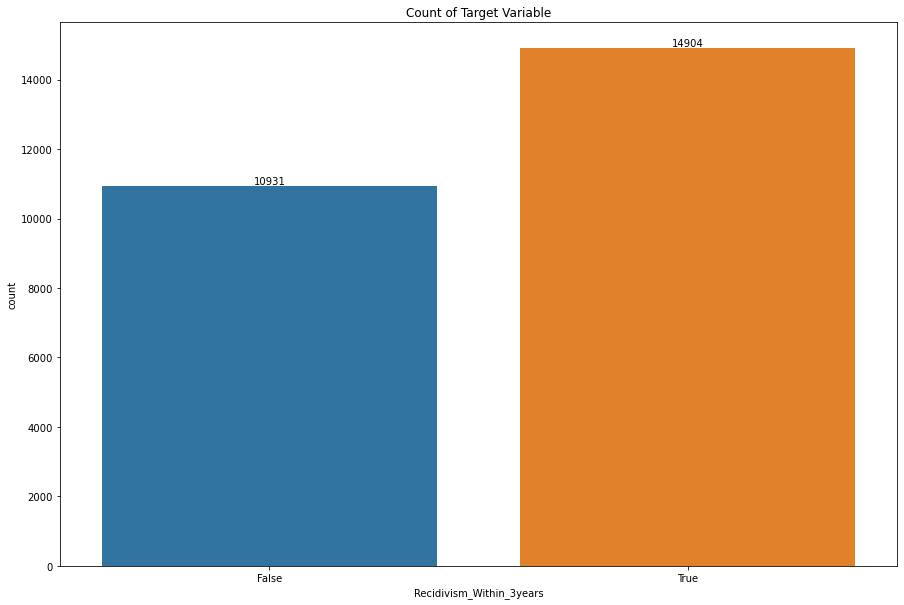

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.countplot(data = data, x = 'Recidivism_Within_3years')
ax.bar_label(ax.containers[0])
ax.set_title("Count of Target Variable")
plt.show()

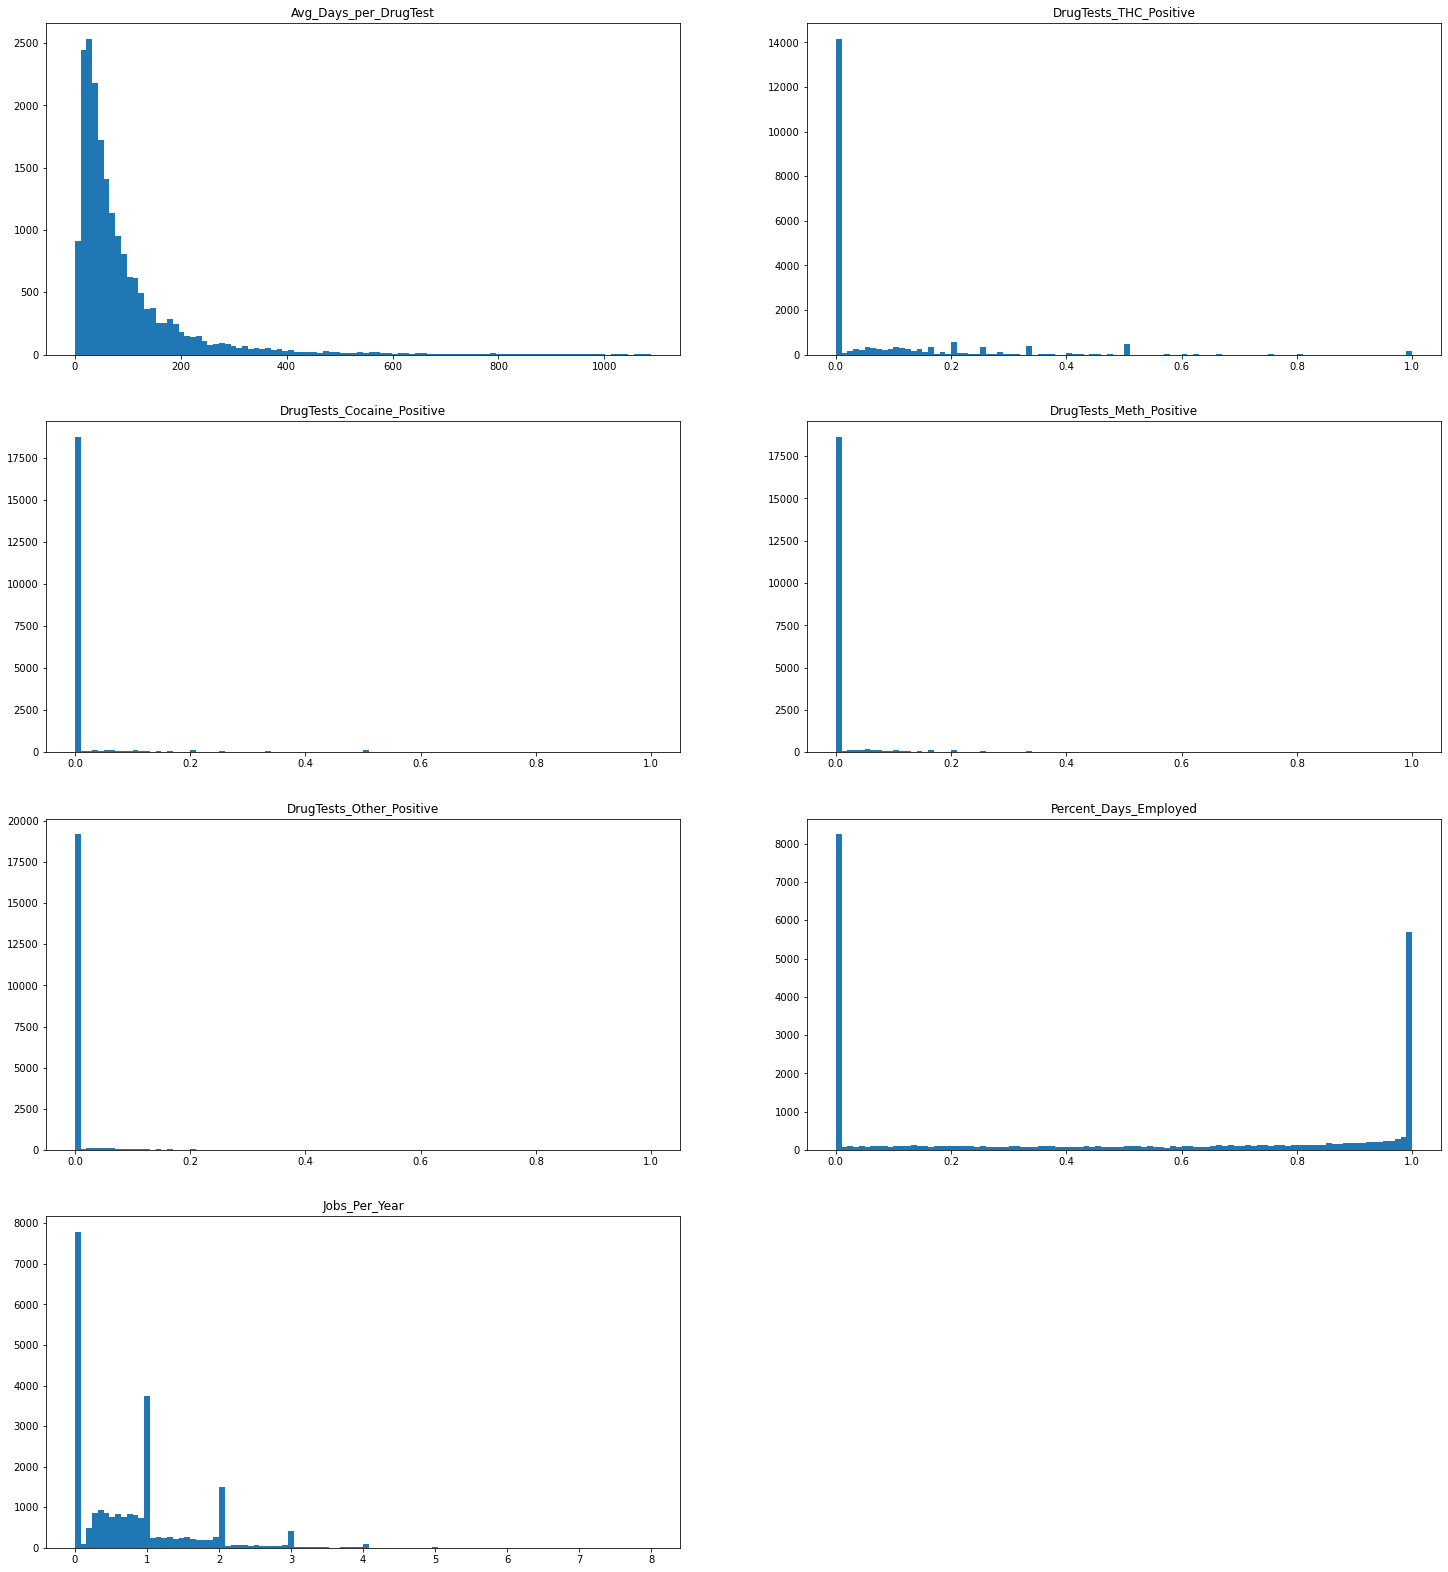

In [ ]:
fig = plt.figure(figsize=(25,50))
for i in range (1,len(num_features)+1):
    ax = plt.subplot(math.ceil(len(num_features)),2,i)
    ax.hist(data[num_features[i-1]], bins=100)
    plt.title(num_features[i-1])
plt.show()

In [ ]:
cat_features2 = [['Gender', 'Race', 'Age_at_Release', 'Residence_PUMA'],
       ['Gang_Affiliated', 'Supervision_Risk_Score_First',
       'Supervision_Level_First', 'Education_Level'], ['Dependents',
       'Prison_Offense', 'Prison_Years', 'Prior_Arrest_Episodes_Felony'],
       ['Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent',
       'Prior_Arrest_Episodes_Property', 'Prior_Arrest_Episodes_Drug'],
       ['Prior_Arrest_Episodes_PPViolationCharges',
       'Prior_Arrest_Episodes_DVCharges', 'Prior_Arrest_Episodes_GunCharges',
       'Prior_Conviction_Episodes_Felony'], ['Prior_Conviction_Episodes_Misd',
       'Prior_Conviction_Episodes_Viol', 'Prior_Conviction_Episodes_Prop',
       'Prior_Conviction_Episodes_Drug'],
       ['Prior_Conviction_Episodes_PPViolationCharges',
       'Prior_Conviction_Episodes_DomesticViolenceCharges',
       'Prior_Conviction_Episodes_GunCharges', 'Prior_Revocations_Parole'],
       ['Prior_Revocations_Probation', 'Condition_MH_SA', 'Condition_Cog_Ed',
       'Condition_Other'], ['Violations_ElectronicMonitoring',
       'Violations_Instruction', 'Violations_FailToReport',
       'Violations_MoveWithoutPermission'], ['Delinquency_Reports',
       'Program_Attendances', 'Program_UnexcusedAbsences', 'Residence_Changes'],
       ['Employment_Exempt']]

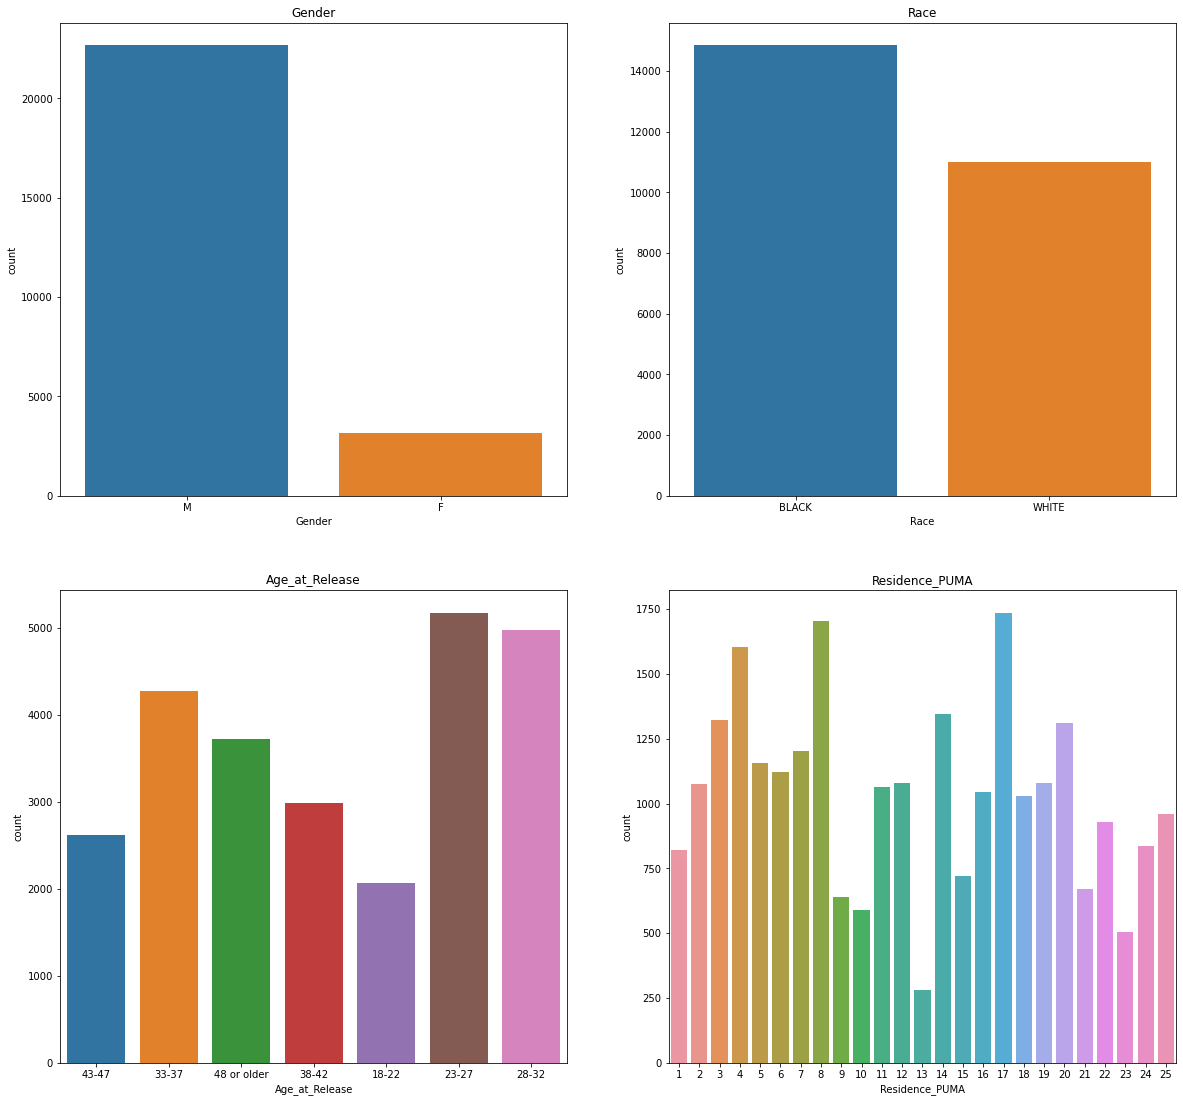

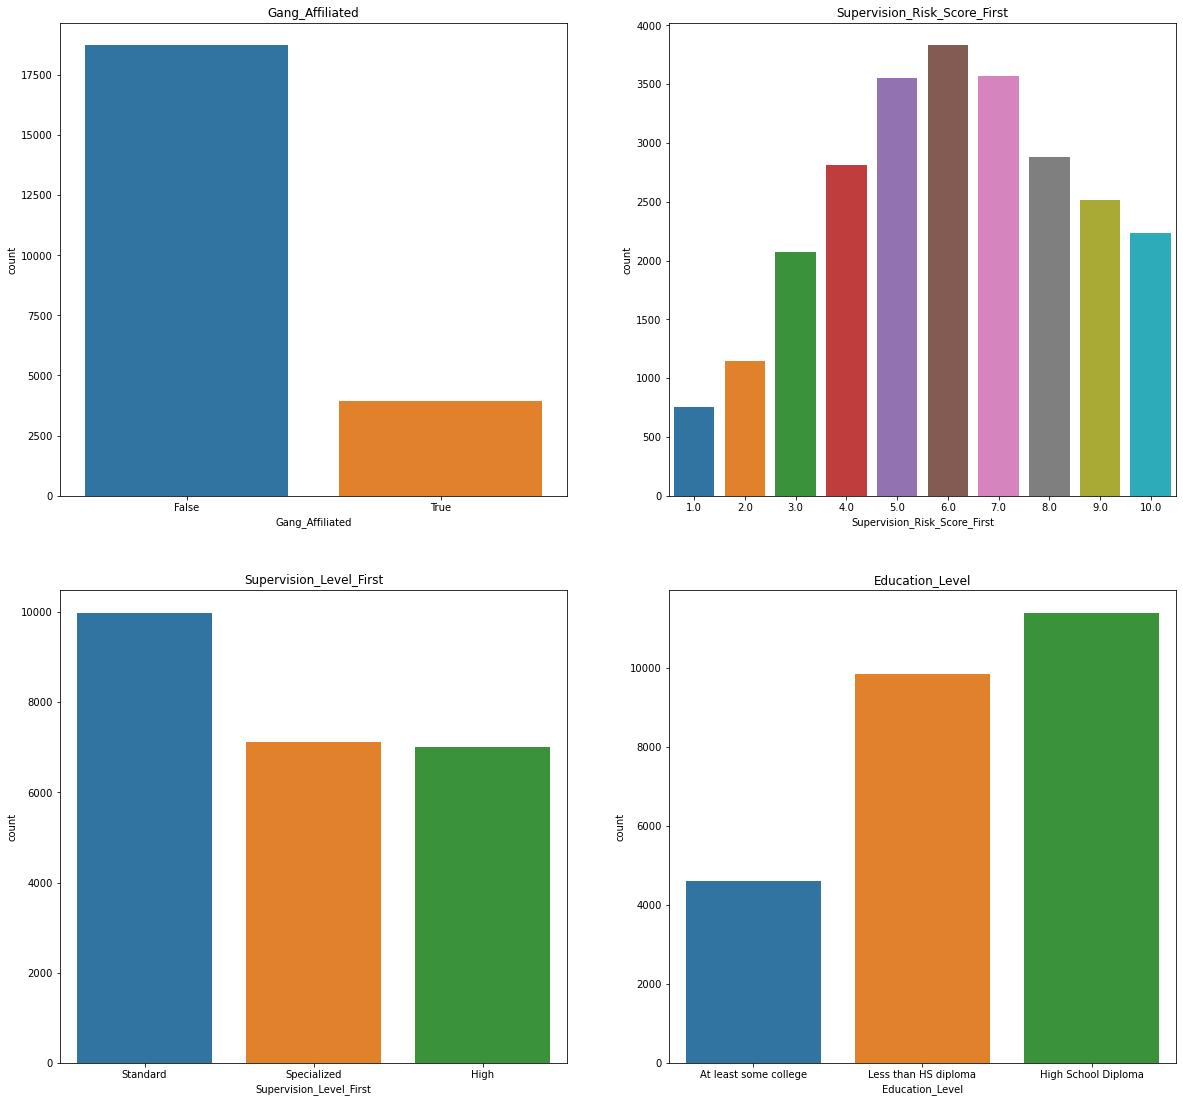

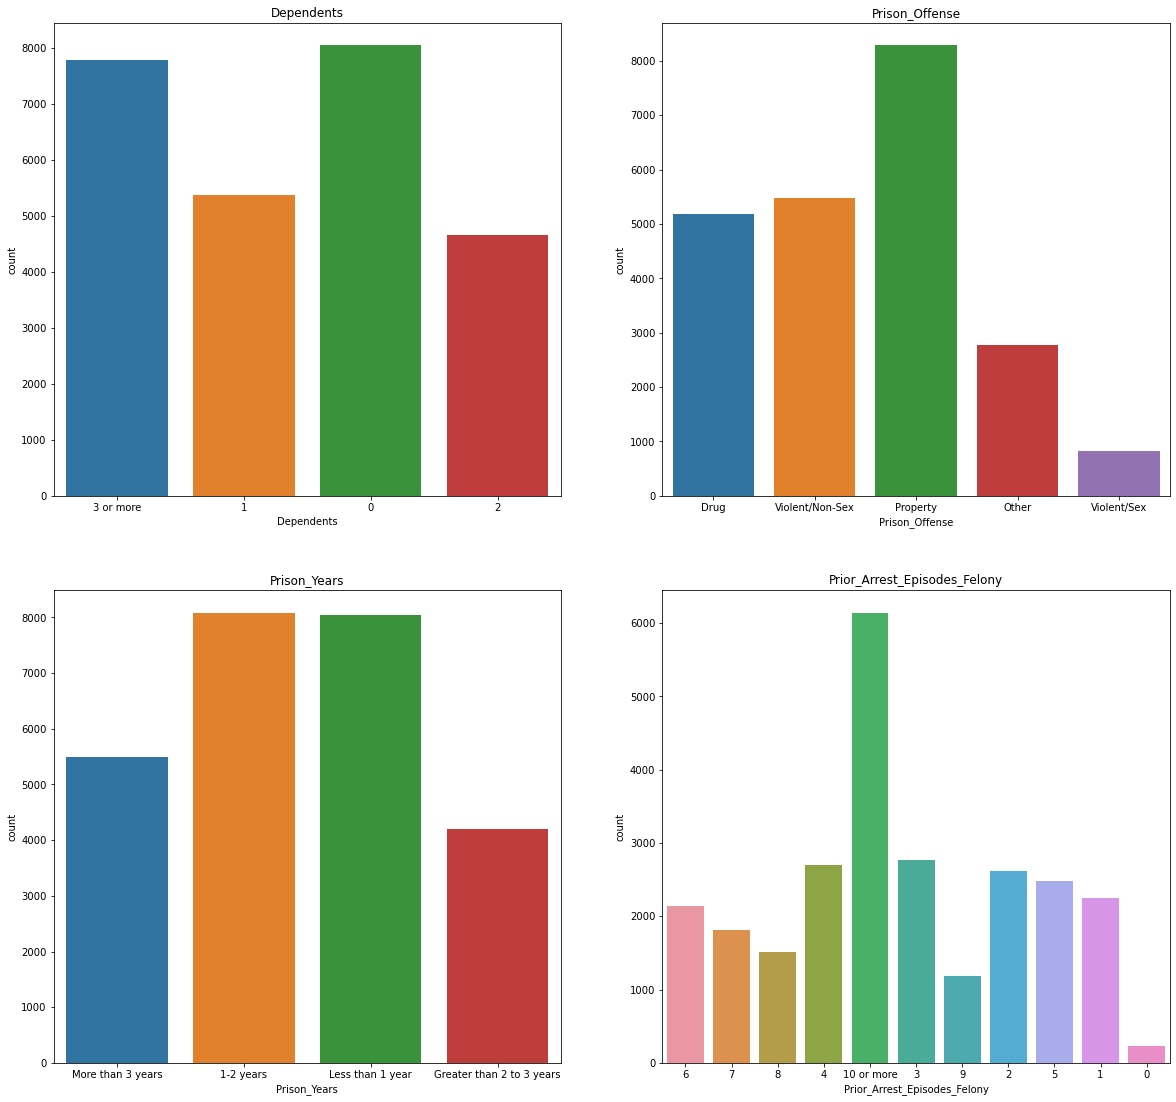

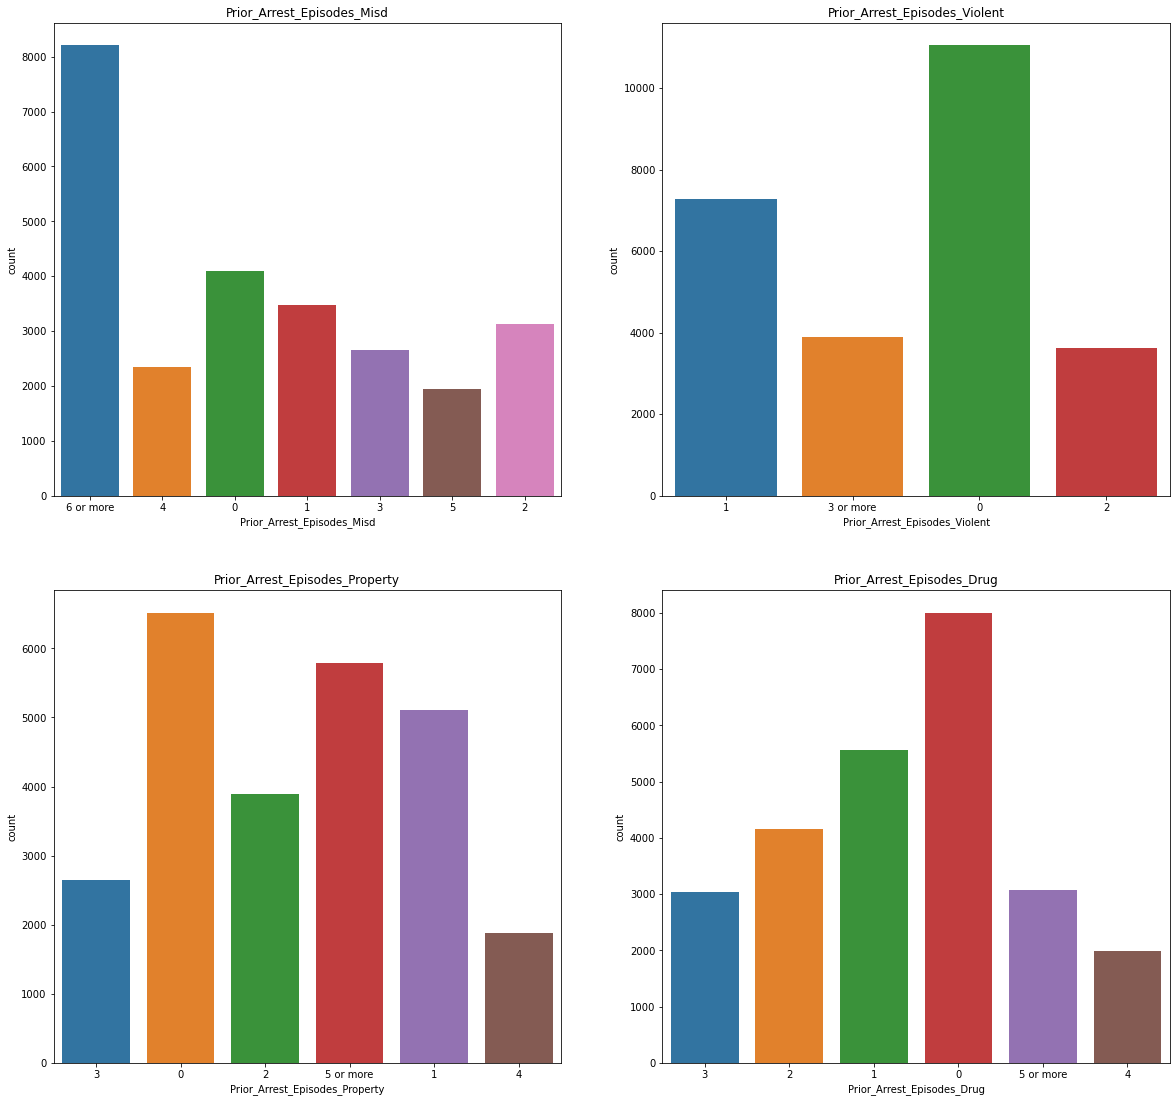

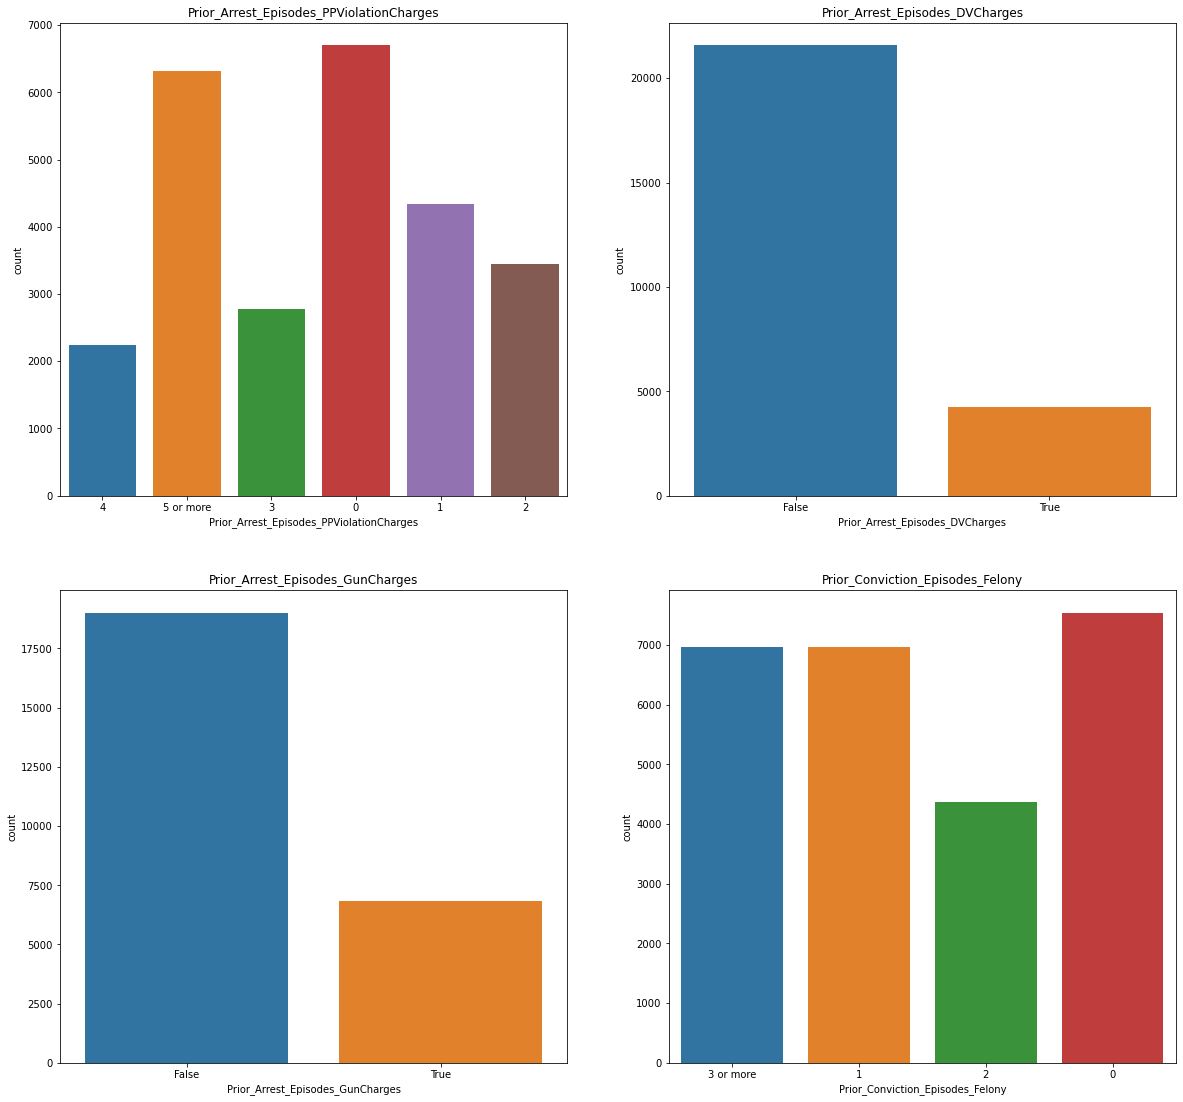

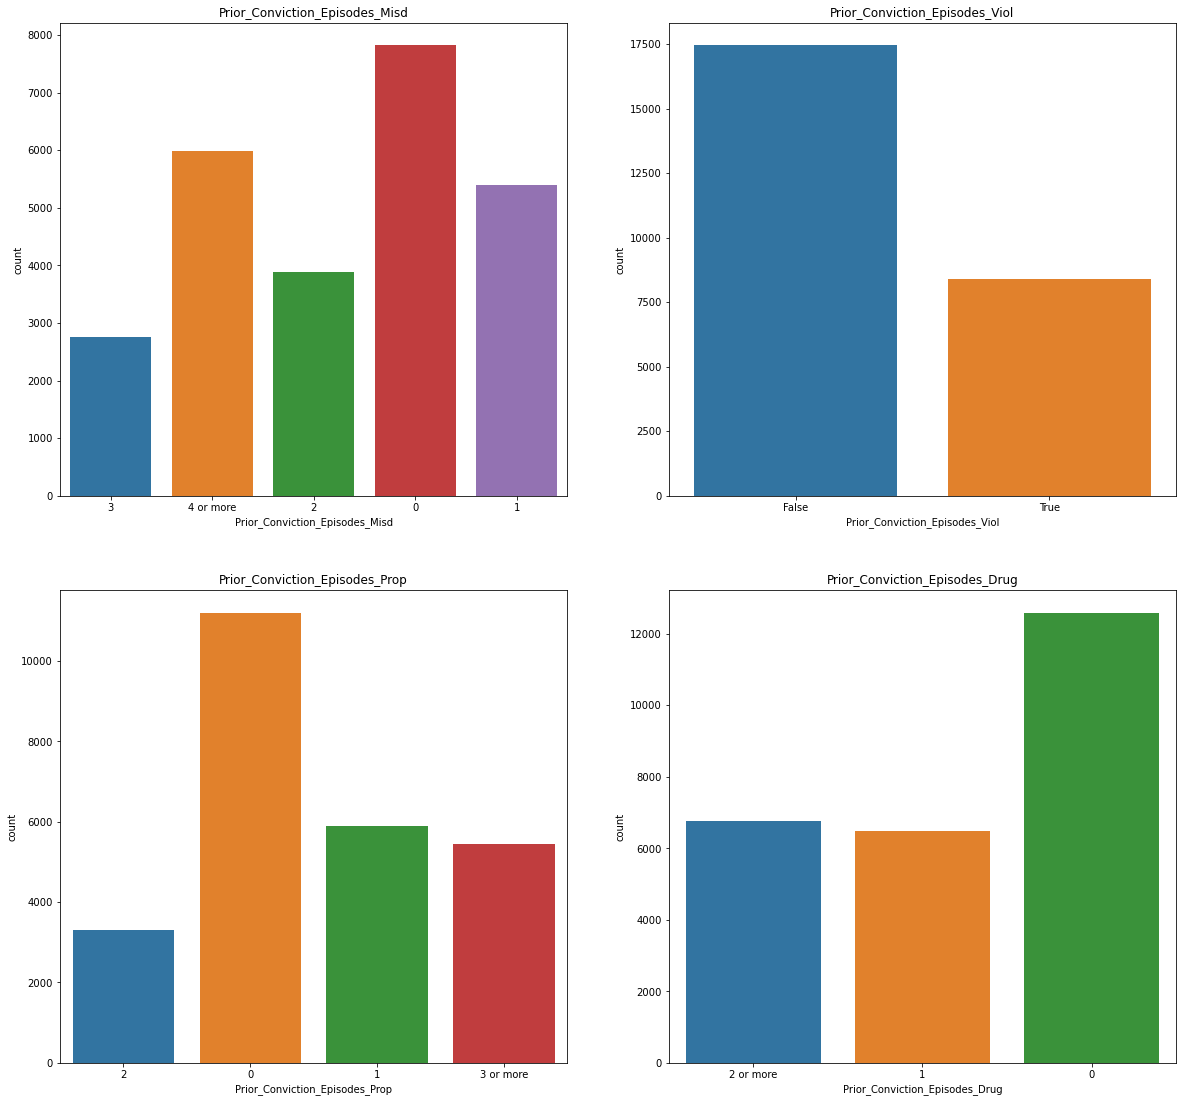

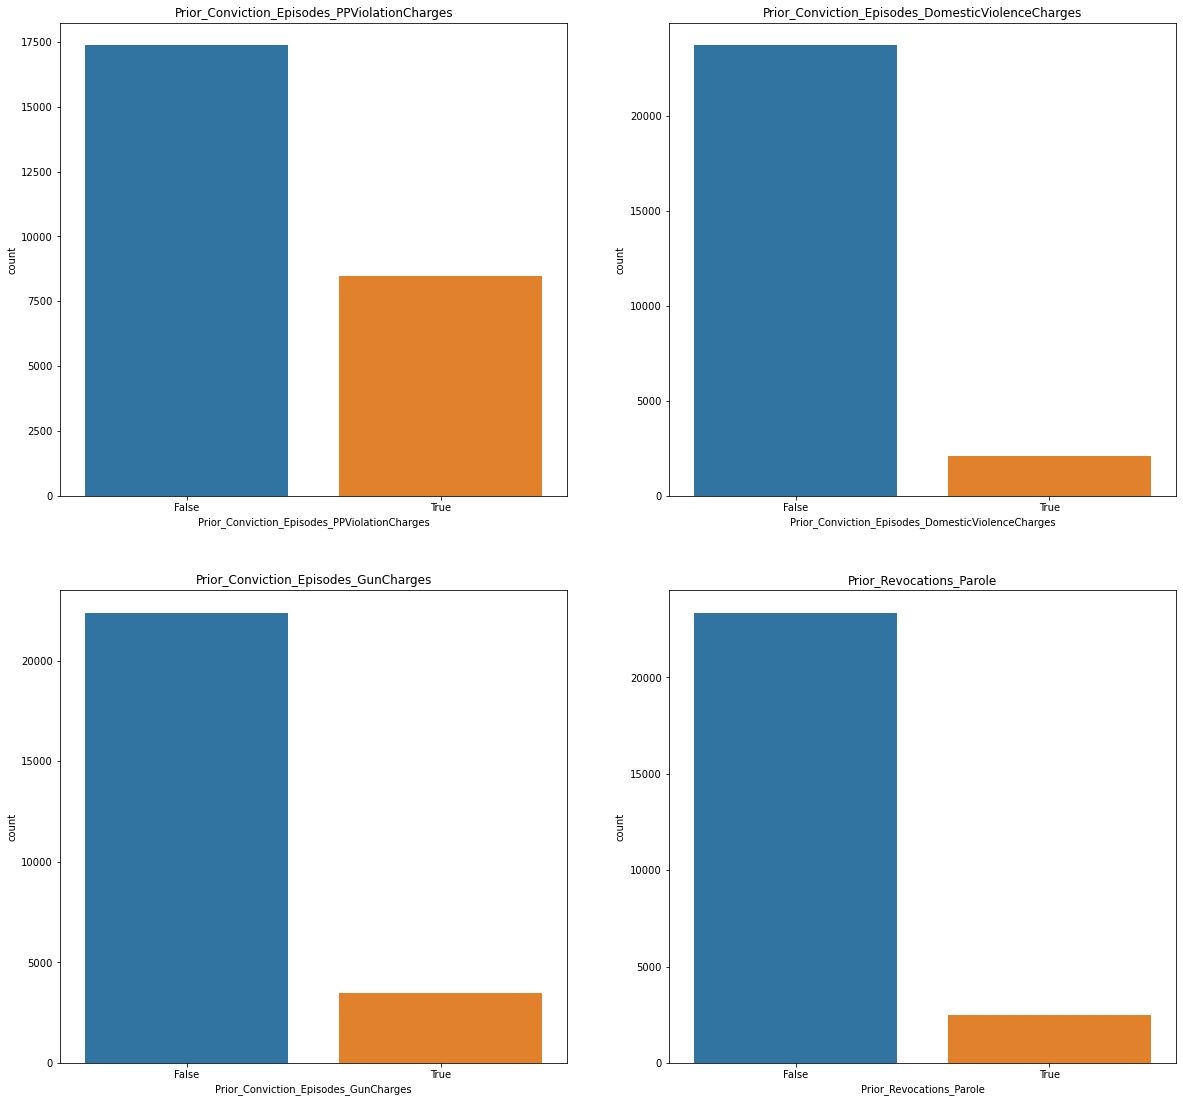

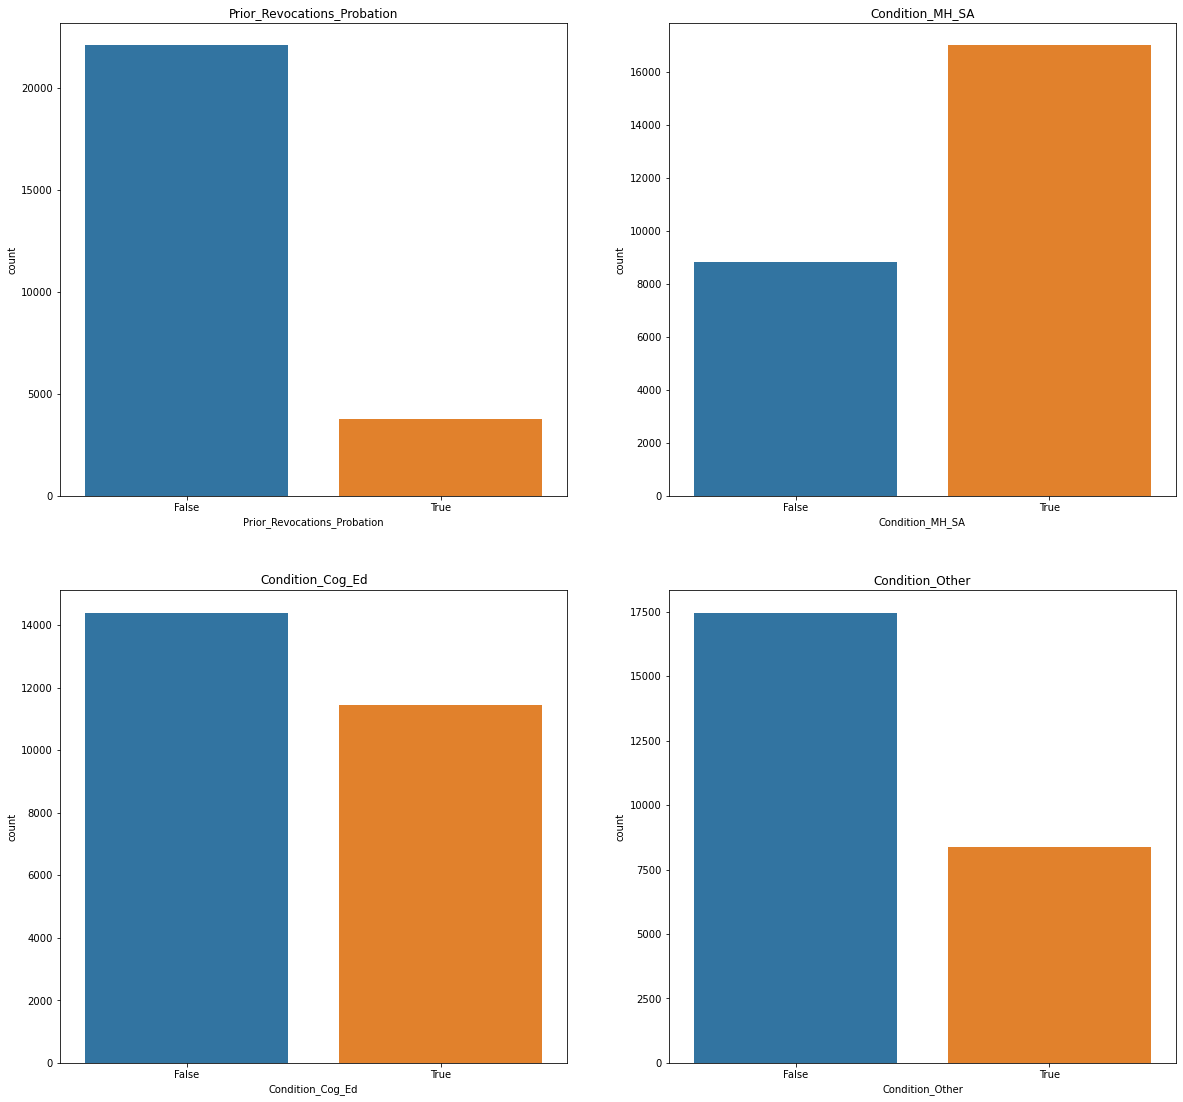

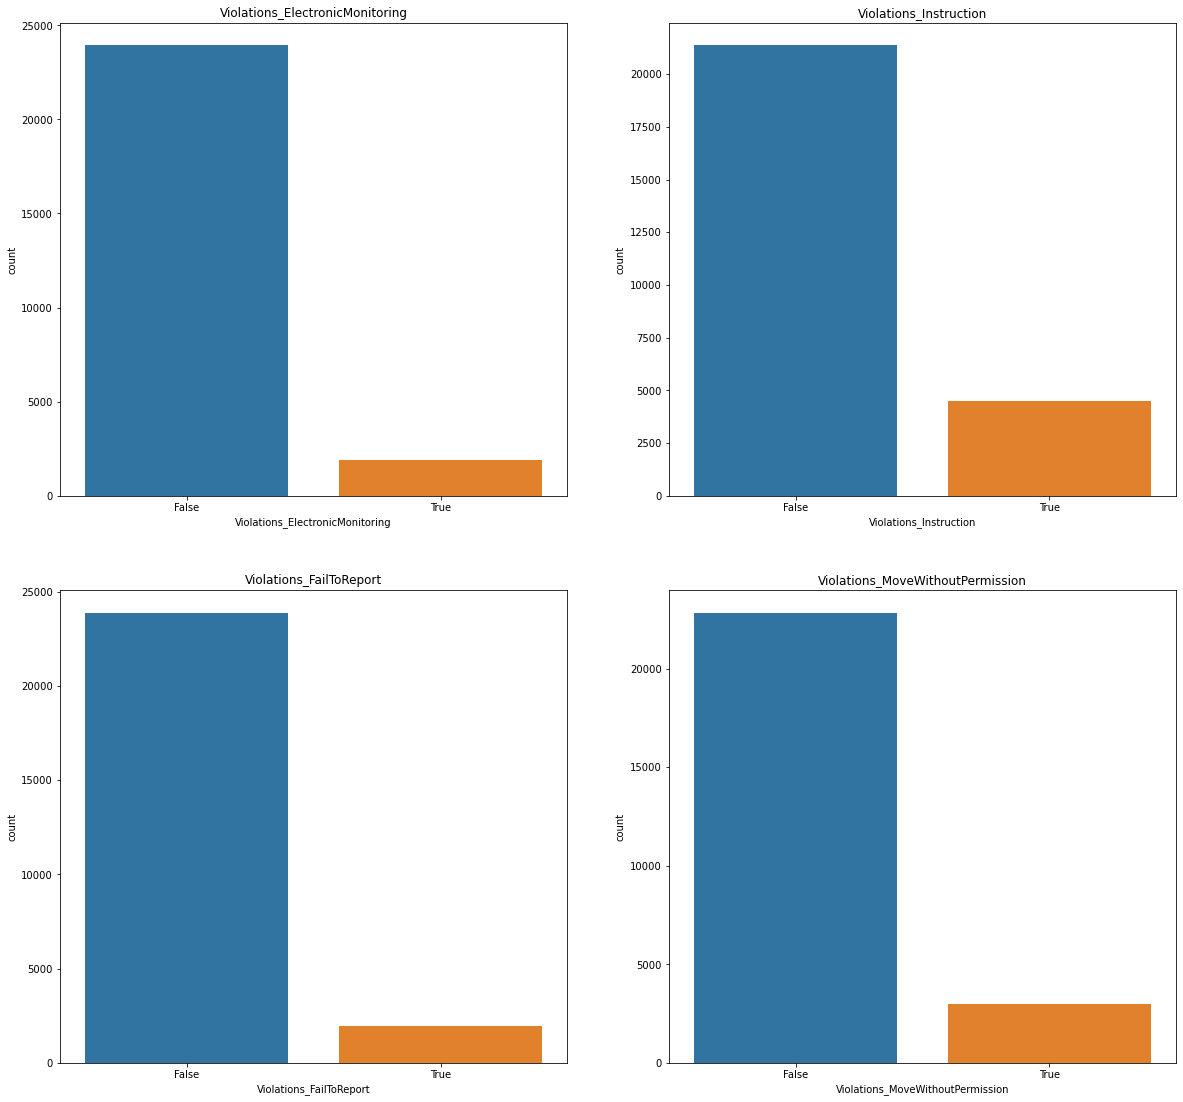

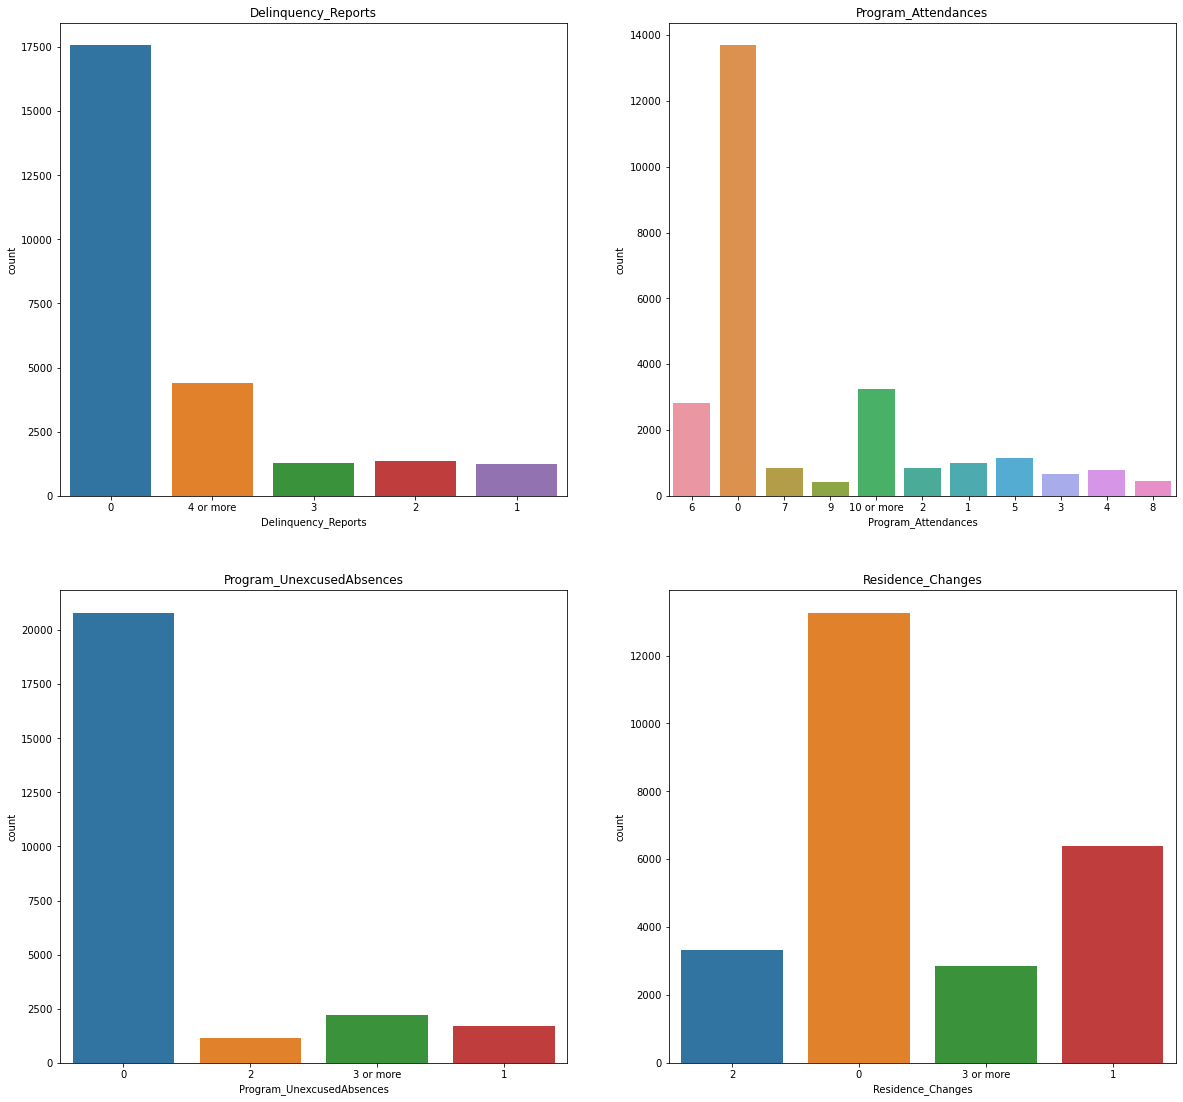

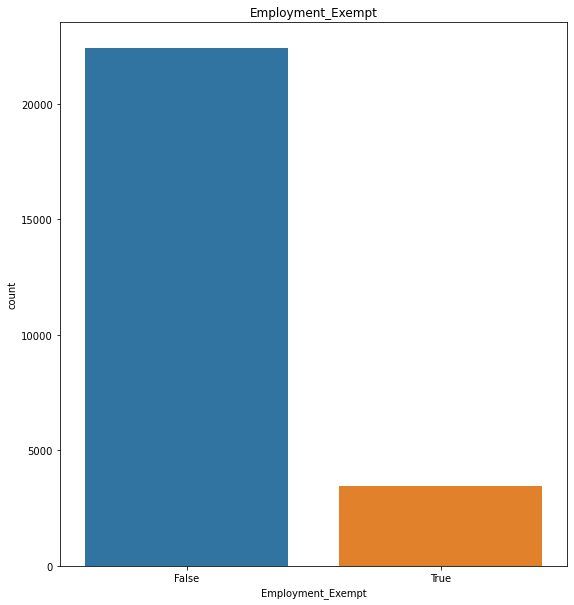

In [ ]:
test = cat_features2[0]
for cats in cat_features2:
    x = 10 * math.ceil(len(cats))
    fig = plt.figure(figsize=(20,x))
    for i in range (1,len(cats)+1):
        ax = plt.subplot(math.ceil(len(cats)),2,i)
        sns.countplot(data = data, x=cats[i-1], ax=ax)
        plt.title(cats[i-1])
    plt.show()

# Investigate Relationships Between Features and Target Variable

## Boxplots for Numberical Features

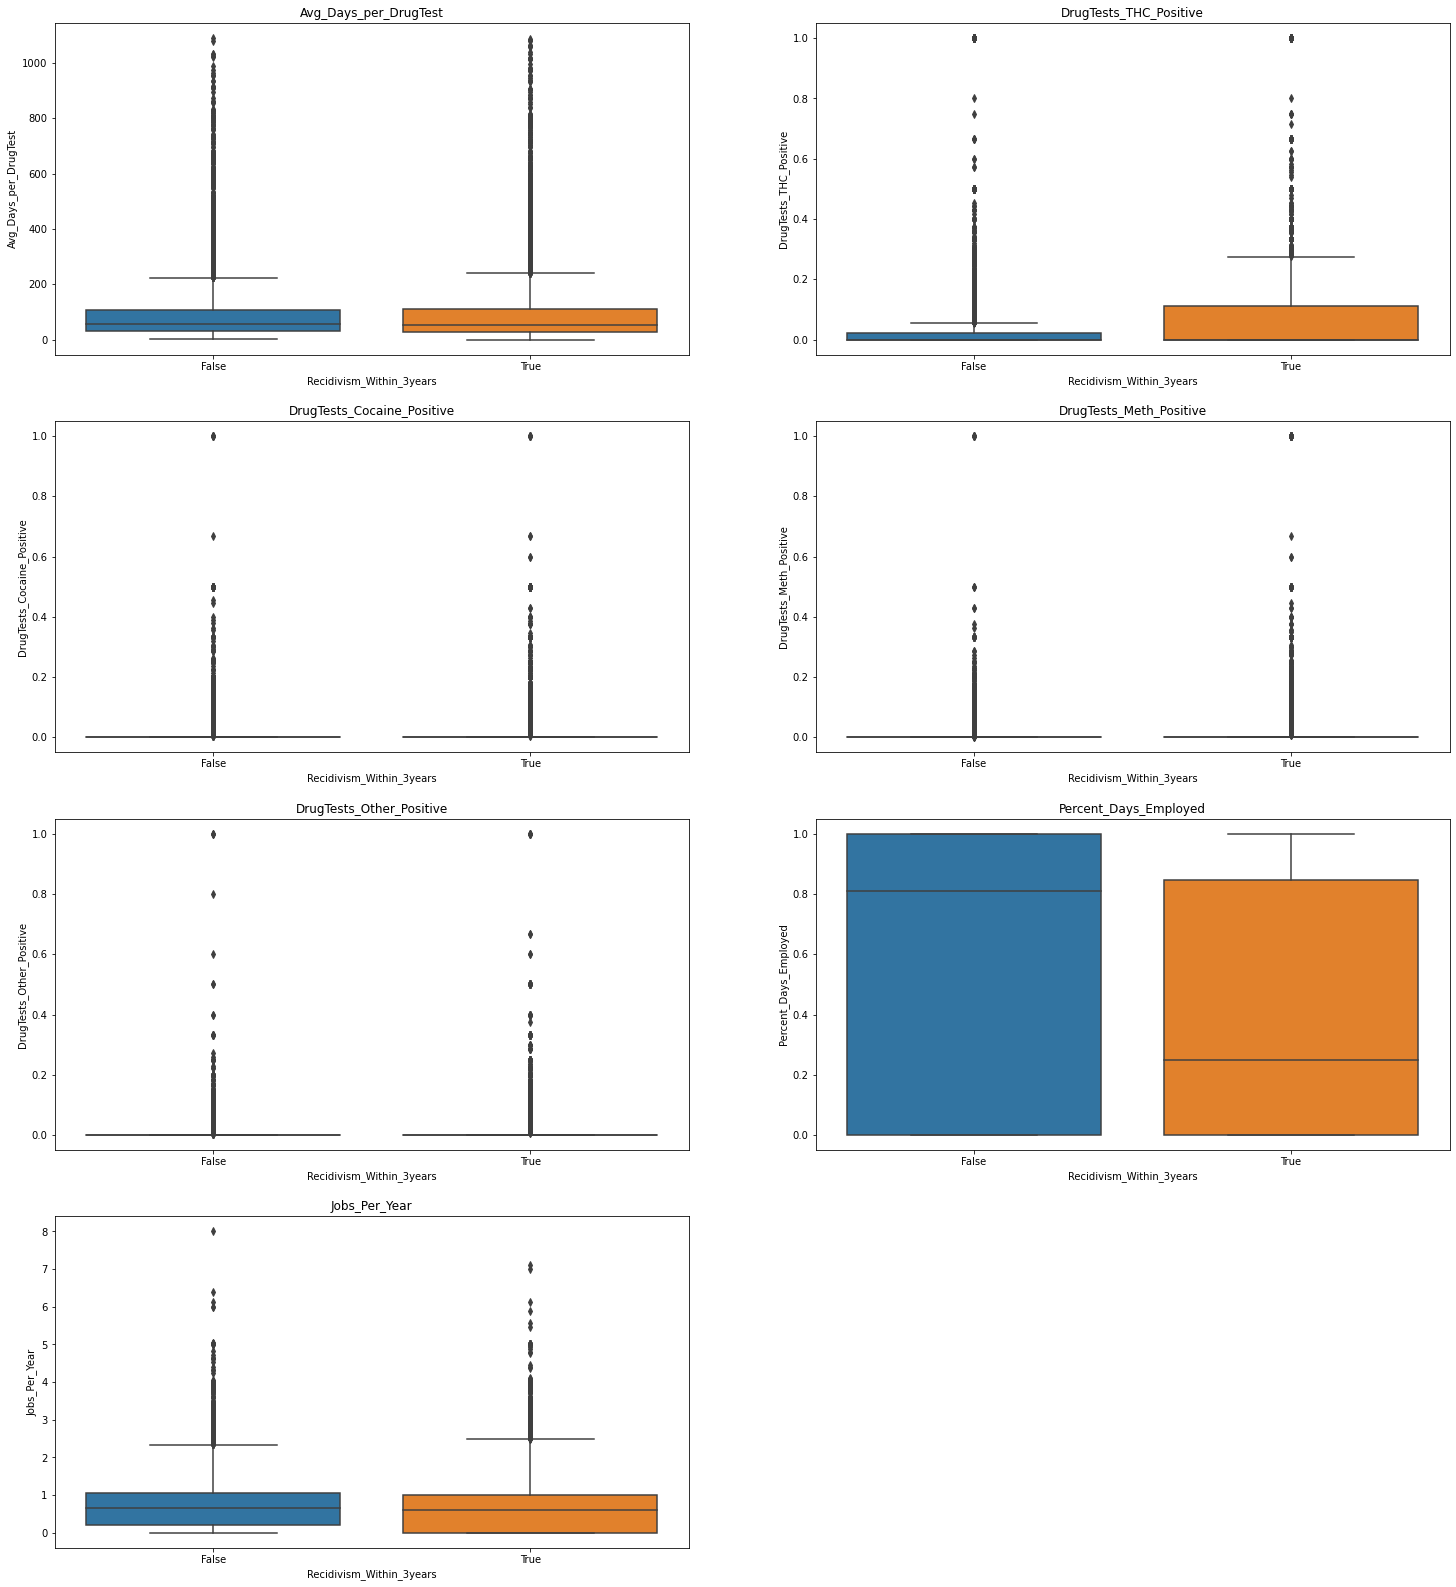

In [ ]:
fig = plt.figure(figsize=(25,50))
for i in range (1,len(num_features)+1):
    ax = plt.subplot(math.ceil(len(num_features)),2,i)
    sns.boxplot(y=data[num_features[i-1]], x=data['Recidivism_Within_3years'])
    plt.title(num_features[i-1])
plt.show()

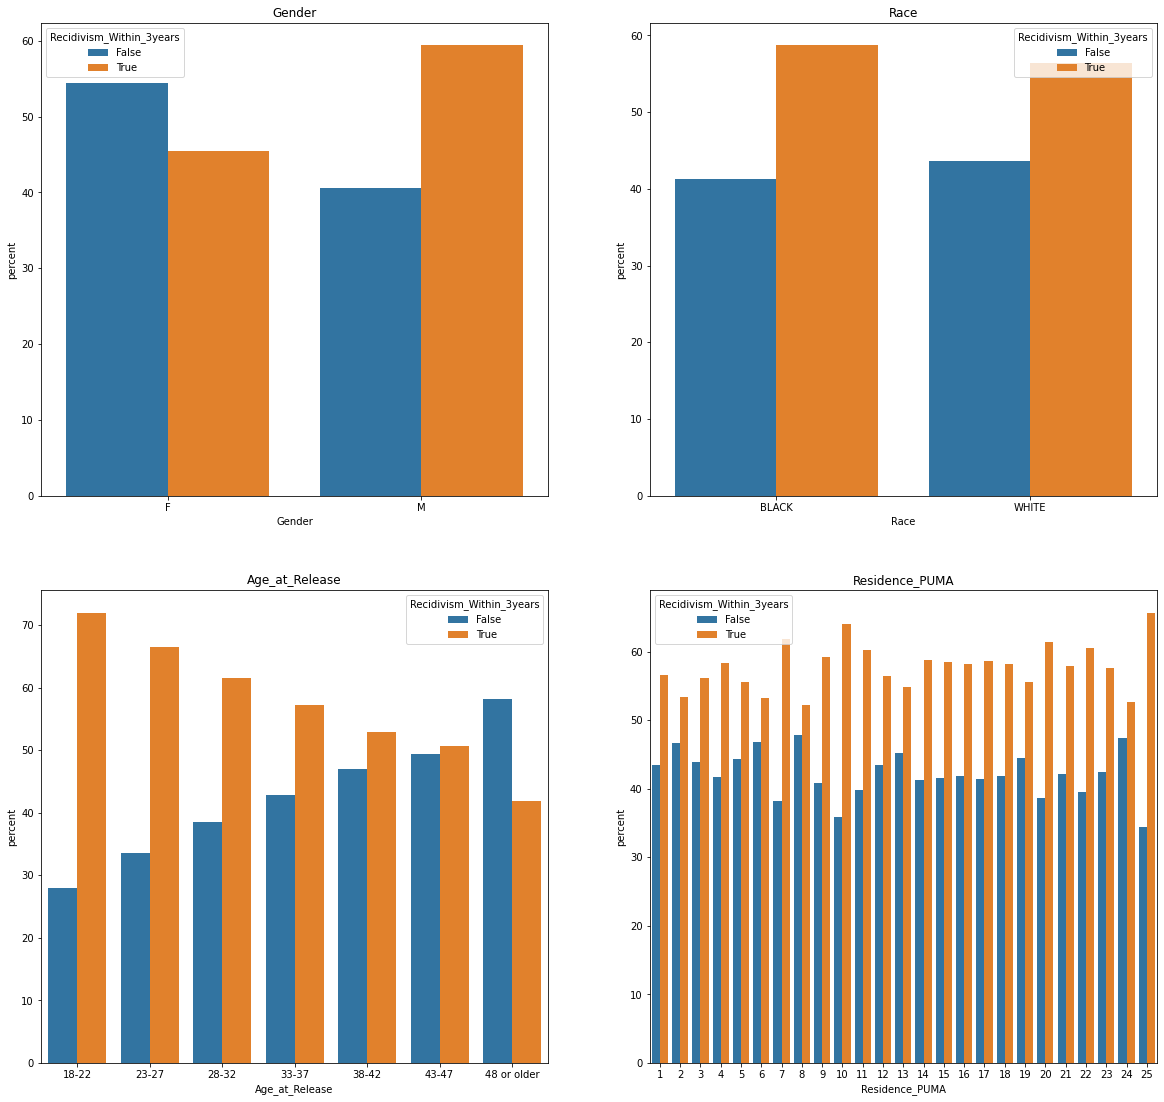

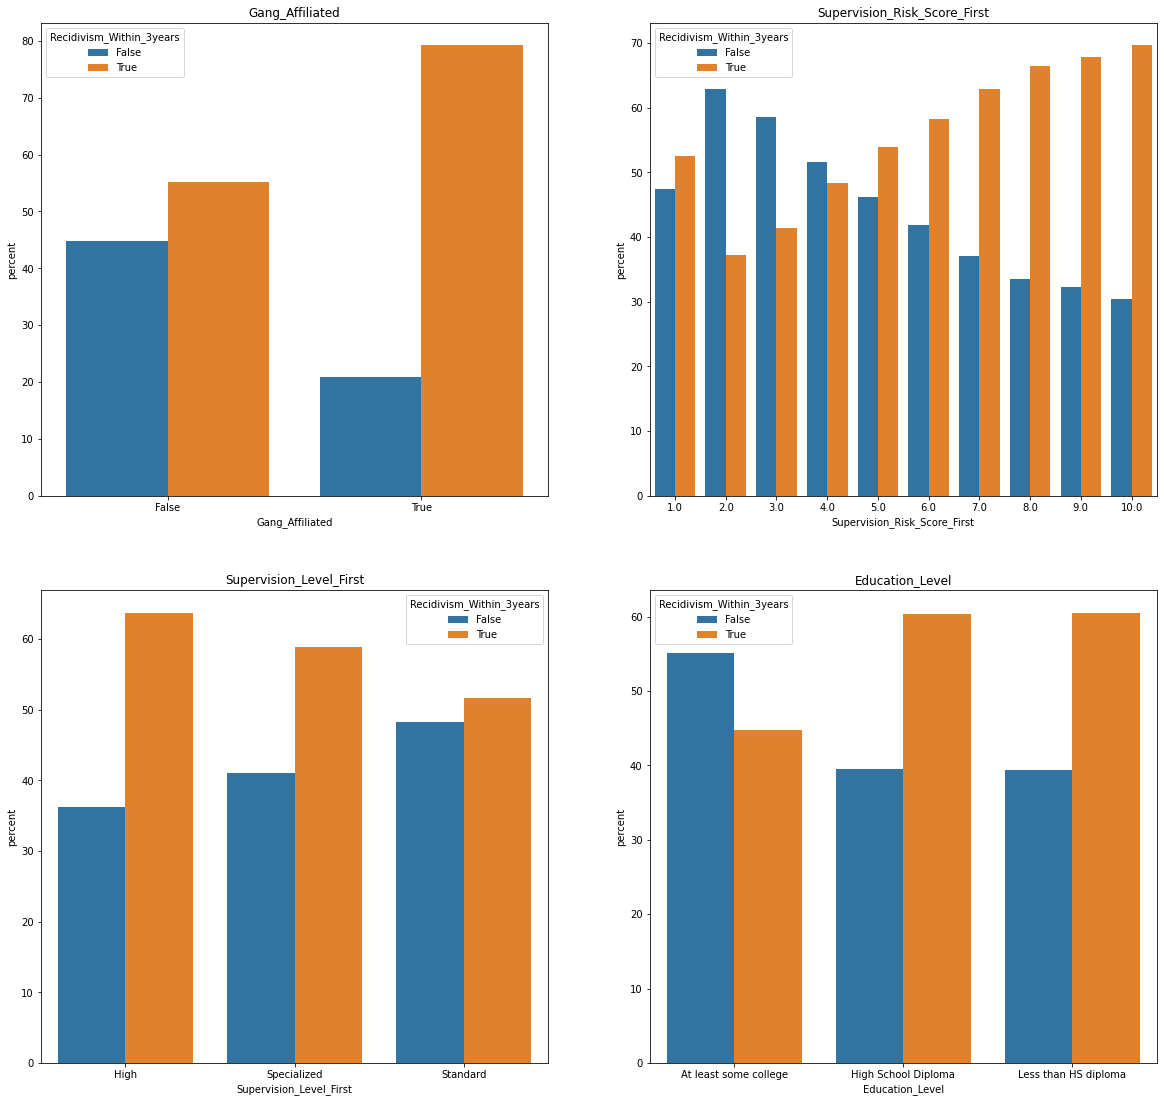

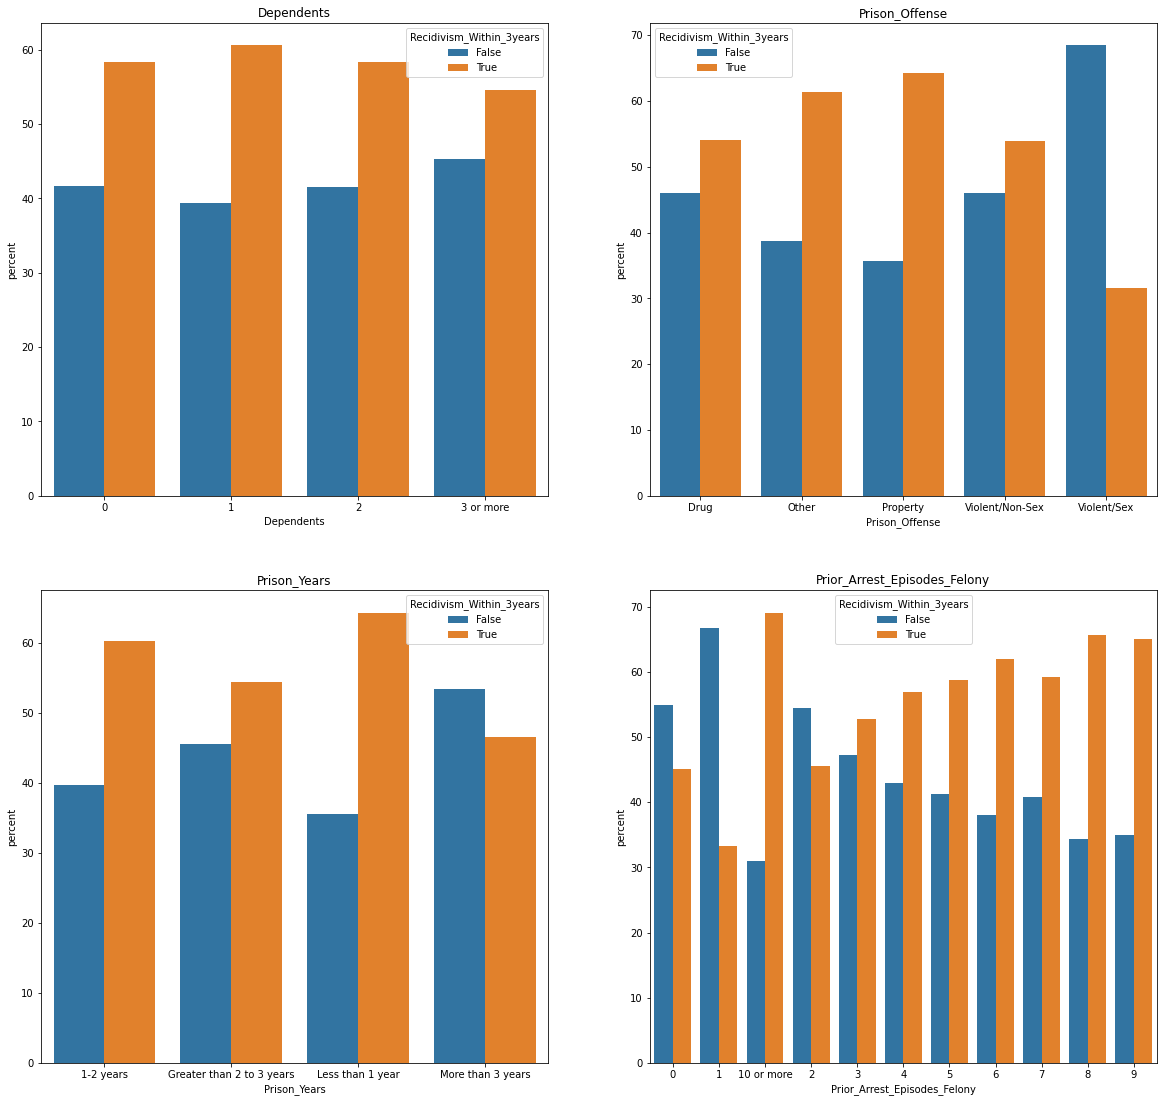

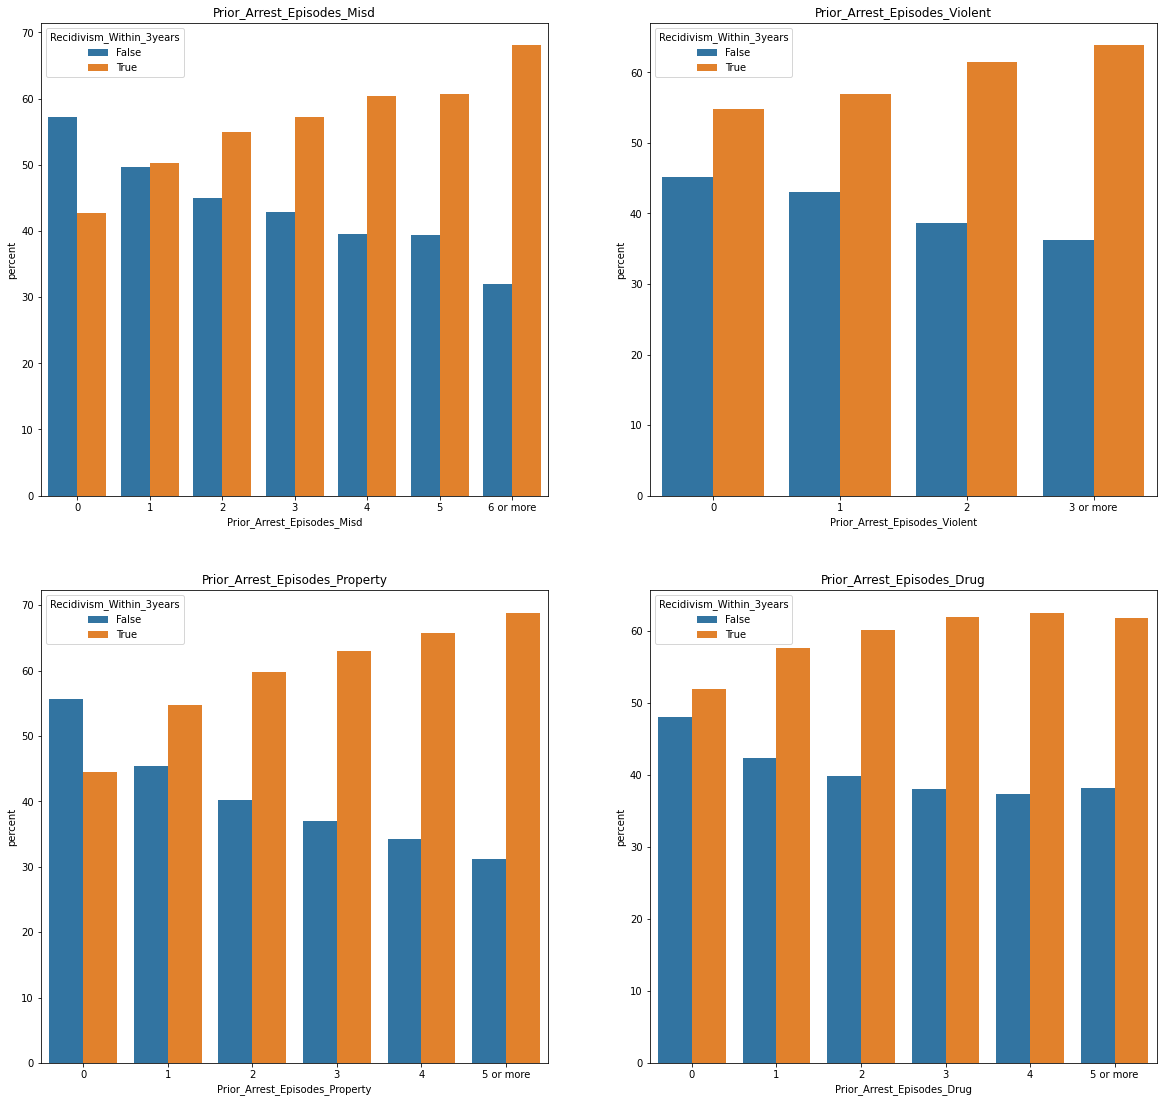

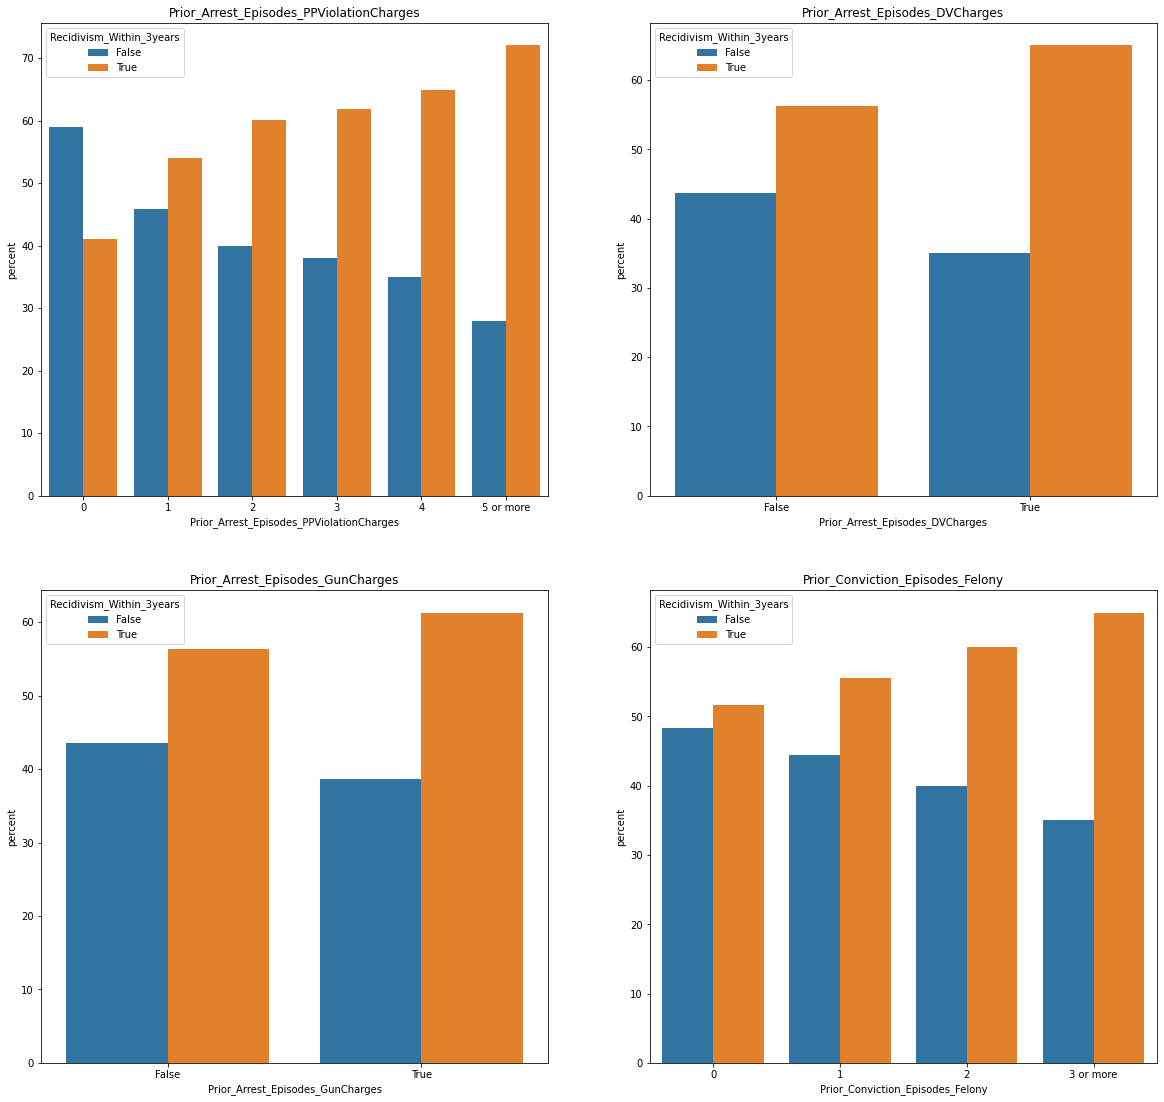

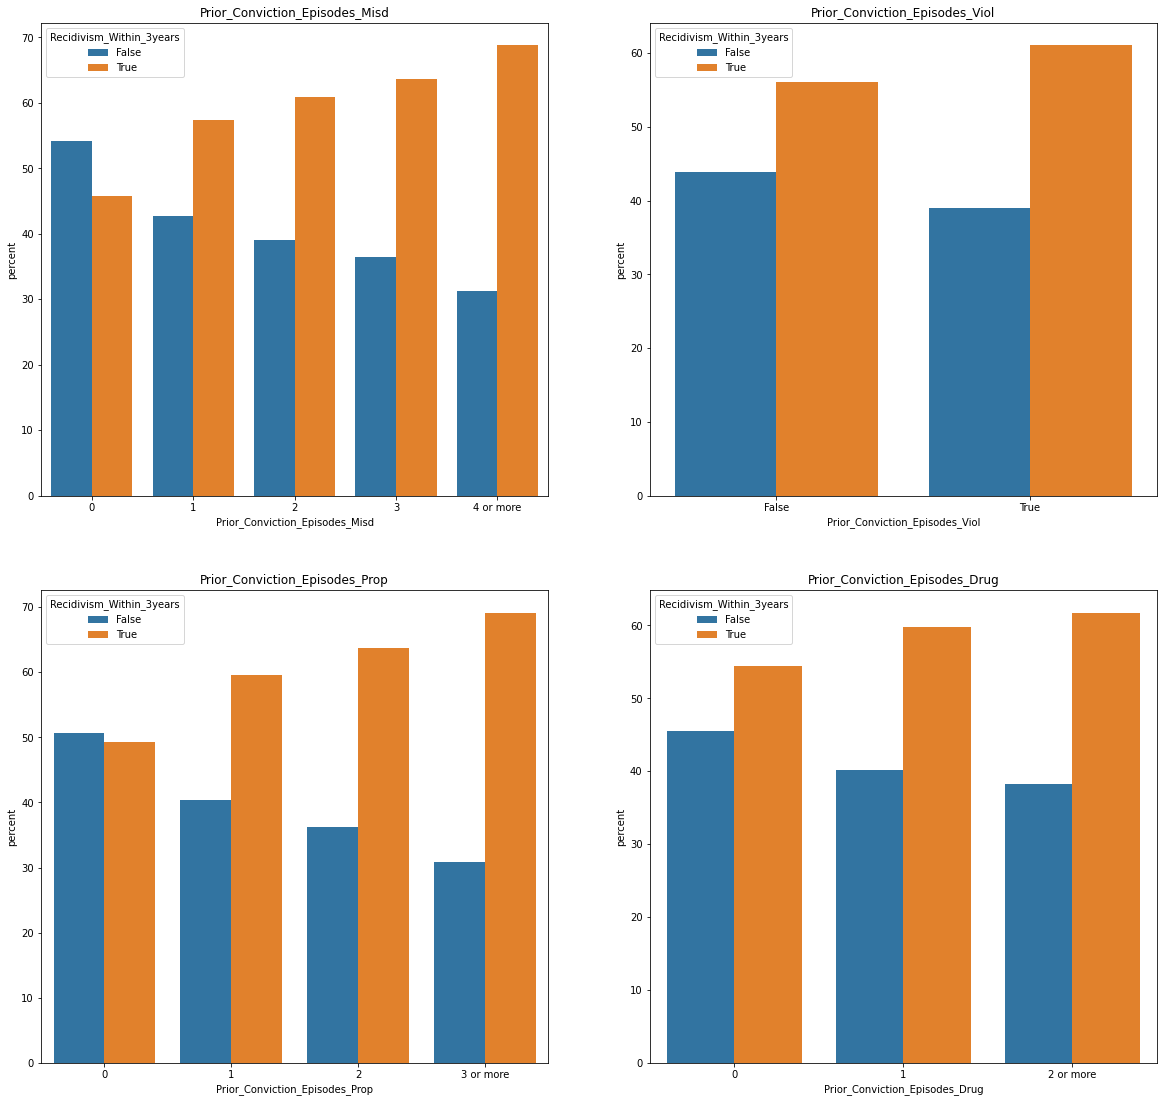

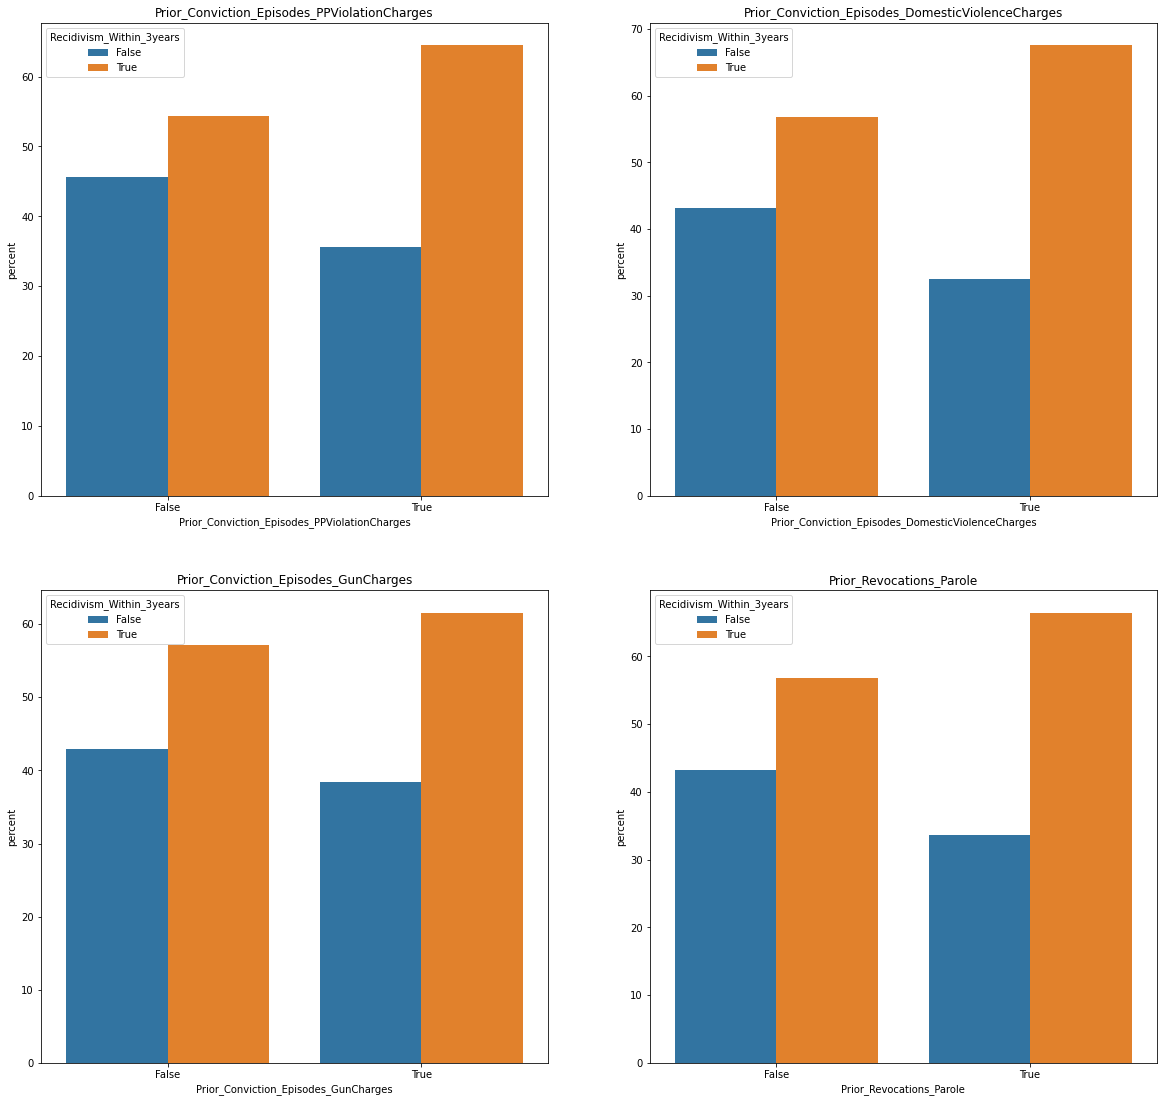

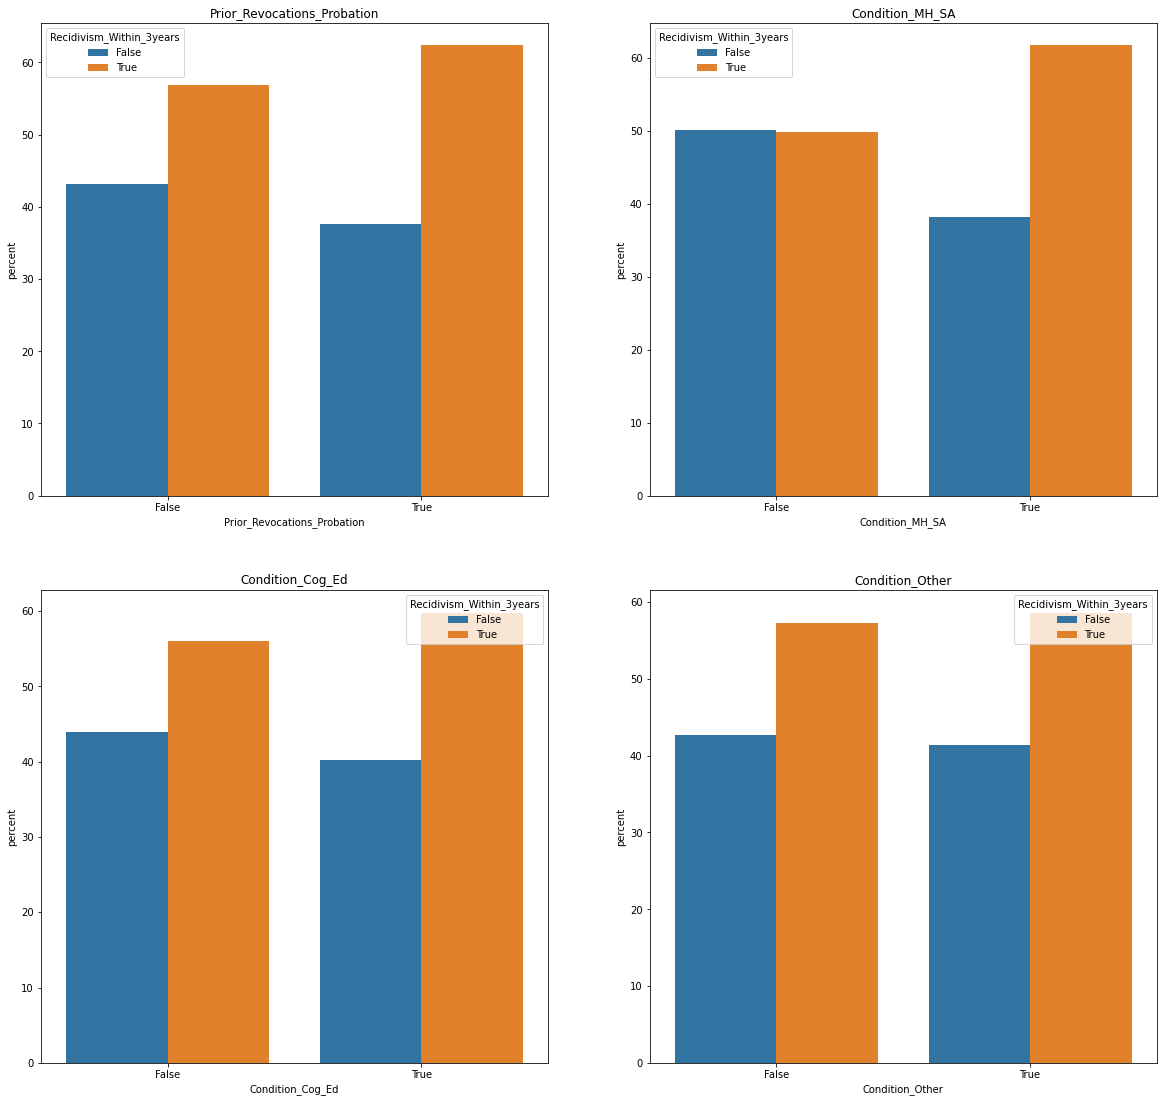

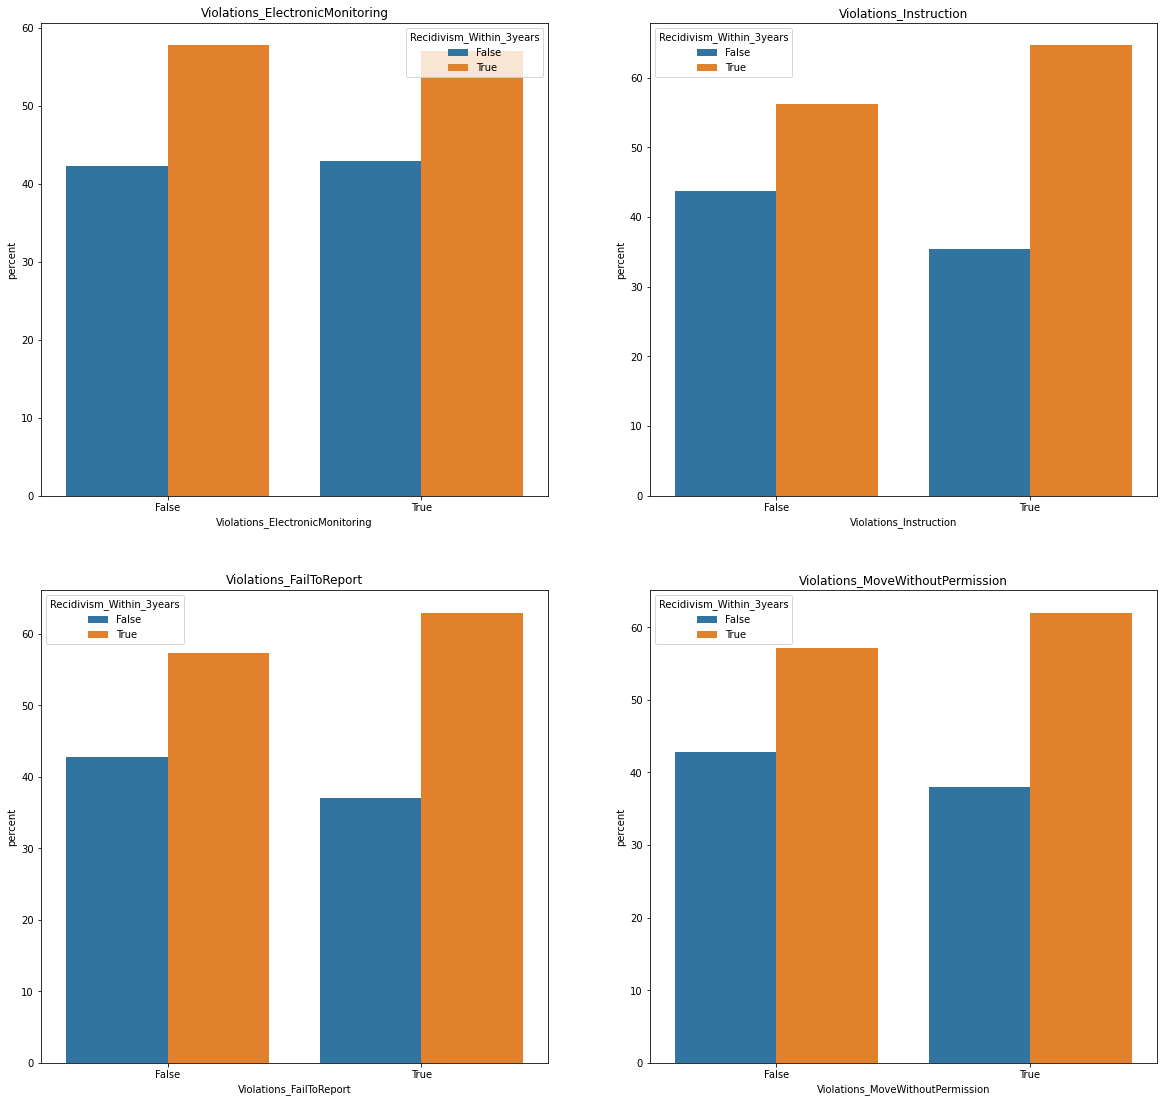

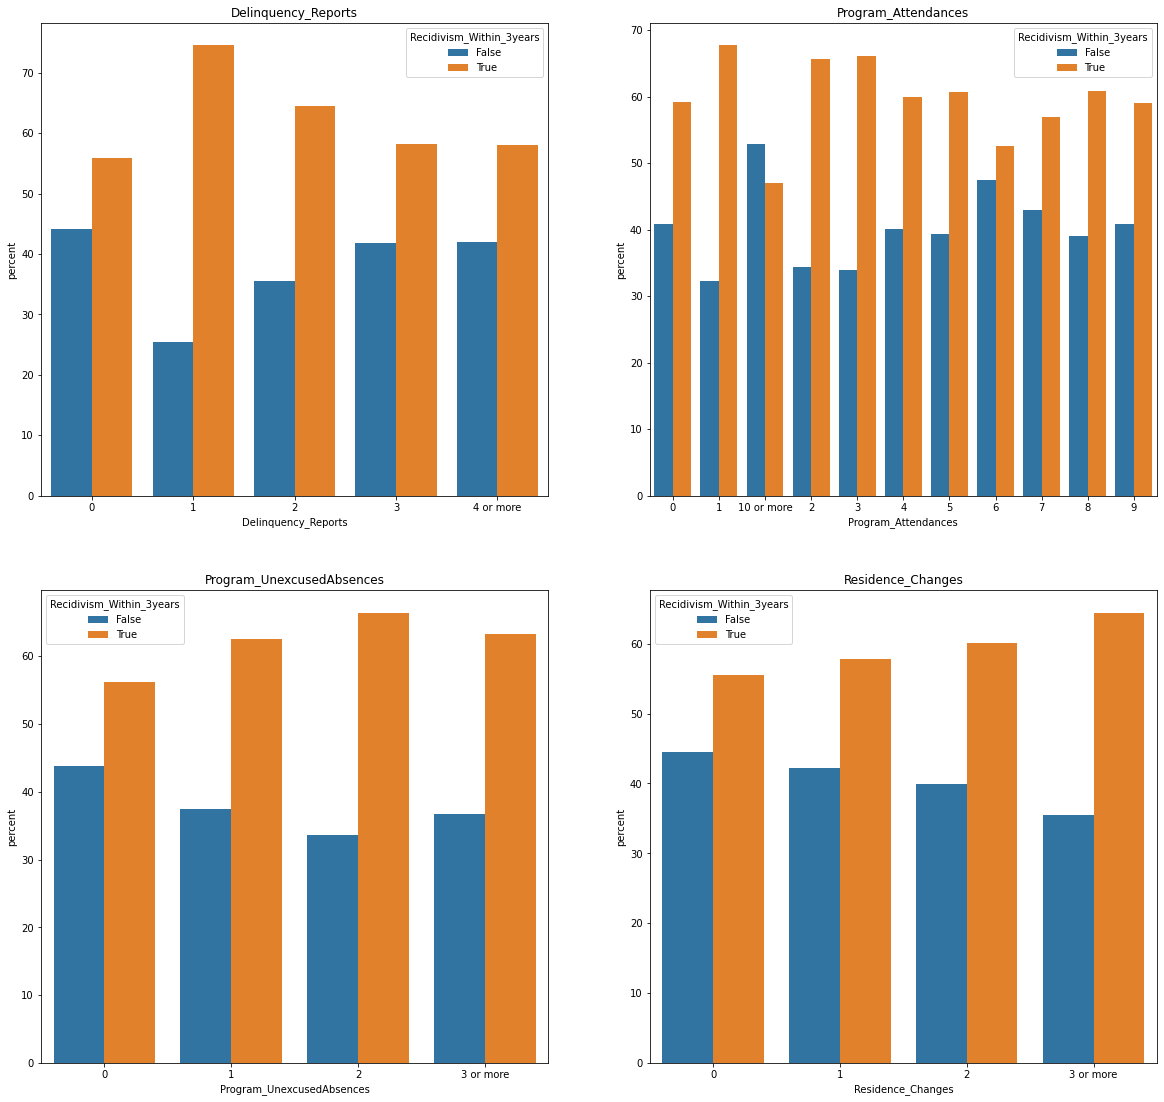

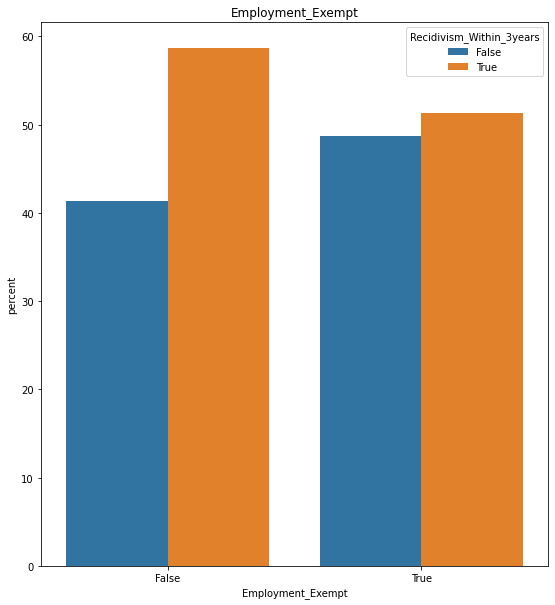

In [ ]:
test = cat_features2[0]
for cats in cat_features2:
    x = 10 * math.ceil(len(cats))
    fig = plt.figure(figsize=(20,x))
    for i in range (1,len(cats)+1):
        ax = plt.subplot(math.ceil(len(cats)),2,i)
        y = 'Recidivism_Within_3years'
        (data.groupby(cats[i-1])['Recidivism_Within_3years'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.barplot, 'data'),x=cats[i-1], y='percent', hue=y, ax=ax))
        plt.title(cats[i-1])
    plt.show()

In [ ]:
num_features

['Avg_Days_per_DrugTest',
 'DrugTests_THC_Positive',
 'DrugTests_Cocaine_Positive',
 'DrugTests_Meth_Positive',
 'DrugTests_Other_Positive',
 'Percent_Days_Employed',
 'Jobs_Per_Year']

## Calculate Test Statistics for Feature/Target Relationships

### T-Test for Numerical Features

In [ ]:


stats = []
pvalues = []
for feature in num_features:
    stat, pvalue = ttest_ind(data[data['Recidivism_Within_3years'] == True][feature], data[data['Recidivism_Within_3years'] == False][feature], nan_policy='omit')
    stats.append(stat)
    pvalues.append(pvalue)

In [ ]:
results = pd.DataFrame(list(zip(stats,pvalues)), index = num_features, columns=['Statistic', 'p-value'])

In [ ]:
results

,Statistic,p-value
Avg_Days_per_DrugTest,1.069703,2.847663e-01
DrugTests_THC_Positive,22.096452,5.919992e-107
DrugTests_Cocaine_Positive,7.745292,9.974189e-15
DrugTests_Meth_Positive,13.027654,1.209735e-38
DrugTests_Other_Positive,6.896678,5.477005e-12
Percent_Days_Employed,-40.018467,0.000000e+00
Jobs_Per_Year,-8.107660,5.394619e-16


### Chi-Squared Test for Categorical Features
Hypothesis = Target is independent of Feature

In [ ]:
chi2 = []
p = []
dof = []
expected = []
for feature in cat_features:
    cross = pd.crosstab(data['Recidivism_Within_3years'], data[feature])
    chi2_score, p_score, dof_value, expected_array = chi2_contingency(cross)
    chi2.append(chi2_score)
    p.append(p_score)
    dof.append(dof_value)
    expected.append(expected_array)
    


    

In [ ]:
cat_results = pd.DataFrame(list(zip(chi2,p,dof)),index=cat_features, columns=['chi2', 'p-value', 'dof'])

In [ ]:
cat_results

,chi2,p-value,dof
Gender,217.987238,2.485577e-49,1
Race,14.093703,1.739251e-04,1
Age_at_Release,826.528406,2.852097e-175,6
Residence_PUMA,114.141737,1.058508e-13,24
Gang_Affiliated,774.865907,1.573165e-170,1
Supervision_Risk_Score_First,918.863529,5.330440e-192,9
Supervision_Level_First,257.337354,1.317964e-56,2
Education_Level,380.213080,2.740177e-83,2
Dependents,50.625741,5.877916e-11,3
Prison_Offense,453.427187,7.887262e-97,4


In [ ]:
data[data['Recidivism_Within_3years'] == True]['DrugTests_Cocaine_Positive'].mean()

0.016707523066871167

In [ ]:
data[data['Recidivism_Within_3years'] == False]['DrugTests_Cocaine_Positive'].mean()

0.0100820266939371

In [ ]:
data[num_features].var(axis=0)

Avg_Days_per_DrugTest         13728.773057
DrugTests_THC_Positive            0.019169
DrugTests_Cocaine_Positive        0.003750
DrugTests_Meth_Positive           0.003670
DrugTests_Other_Positive          0.001693
Percent_Days_Employed             0.180628
Jobs_Per_Year                     0.662250
dtype: float64

In [ ]:
data[cat_features].var(numeric_only=True)

Residence_PUMA                                       50.890272
Supervision_Risk_Score_First                          5.671264
Prior_Arrest_Episodes_DVCharges                       0.137916
Prior_Arrest_Episodes_GunCharges                      0.194395
Prior_Conviction_Episodes_Viol                        0.219270
Prior_Conviction_Episodes_PPViolationCharges          0.220346
Prior_Conviction_Episodes_DomesticViolenceCharges     0.074972
Prior_Conviction_Episodes_GunCharges                  0.115853
Prior_Revocations_Parole                              0.086563
Prior_Revocations_Probation                           0.124554
Condition_MH_SA                                       0.224940
Condition_Cog_Ed                                      0.246743
Condition_Other                                       0.219107
Violations_ElectronicMonitoring                       0.068402
Violations_Instruction                                0.143116
Violations_FailToReport                               0

### Conduct Mann-Whitney test
Determine if there is a statistically significant difference between numerical features based upon target variable

In [ ]:
from scipy.stats import mannwhitneyu



drugTests = ['DrugTests_THC_Positive',
       'DrugTests_Cocaine_Positive', 'DrugTests_Meth_Positive',
       'DrugTests_Other_Positive']

In [ ]:
stats = []
pvalues = []
for test in num_features:
    data2 = data[data[test].notnull()]
    stat, pvalue = mannwhitneyu(data2[data2['Recidivism_Within_3years'] == True][test],data2[data2['Recidivism_Within_3years'] == False][test])
    stats.append(stat)
    pvalues.append(pvalue)

results = pd.DataFrame(list(zip(stats,pvalues)),index=num_features, columns=['statsistic', 'p-value'])

In [ ]:
results

,statsistic,p-value
Avg_Days_per_DrugTest,46273899.0,1.602425e-03
DrugTests_THC_Positive,59532459.0,5.699052e-82
DrugTests_Cocaine_Positive,53693536.5,2.336331e-05
DrugTests_Meth_Positive,55290700.5,7.760927e-30
DrugTests_Other_Positive,53302602.5,7.631850e-03
Percent_Days_Employed,58449431.0,2.455530e-265
Jobs_Per_Year,69129124.0,2.962256e-30


### Compare Summary Statistics for Drug Test Positive Features Grouped By Target Variable

In [ ]:
data[data['Recidivism_Within_3years'] == True][drugTests].describe()

,DrugTests_THC_Positive,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive
count,11410.000000,11410.000000,11410.000000,11410.000000
mean,0.082293,0.016708,0.017814,0.009326
std,0.158806,0.068397,0.072964,0.047066
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.111111,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
data[data['Recidivism_Within_3years'] == False][drugTests].describe()

,DrugTests_THC_Positive,DrugTests_Cocaine_Positive,DrugTests_Meth_Positive,DrugTests_Other_Positive
count,9253.000000,9253.000000,9253.000000,9253.000000
mean,0.039990,0.010082,0.006818,0.005360
std,0.103549,0.050799,0.039552,0.032268
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.022222,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


## Remove Violoations_ElectronicMonitoring



In [ ]:
data.drop(columns=['Violations_ElectronicMonitoring'], inplace=True)
# data.to_csv("../data/02_interim/cleaned_raw_data_final.csv", header=True, index=False)
dir = os.path.join(basedir,interim_datadir,"cleaned_raw_data_final.csv")
data.to_csv(dir, header=True, index=False)

'/Users/thomaschampion/Dropbox/Programming/Projects/recidivism/data/02_interim/cleaned_raw_data_final.csv'